In [1]:
import healpy as h
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
sys.path.append(os.path.abspath('/Users/adityarotti/Documents/Work/core_codes/generate_apodized_mask/'))
from modules.settings import global_mmf_settings as gset
from modules.data_preprocess import preprocess_planck_data as ppd
from modules.masking import gen_masks
from modules.master import binned_master as bm
from astropy.io import fits
from copy import copy,deepcopy
import pymain as gen_apo_mask
%pylab notebook

from scipy.interpolate import interp1d
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

import collections
result_path="../../results/yy_spec/" ; ensure_dir(result_path)
datapath="/Users/adityarotti/Documents/Work/Data/Planck/"
import pandas as pd
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"

figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cosmo_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)

In [3]:
do_dgrade=True ; nsideout=2048
lmax=1500
masklmax=2*nsideout
snr_cutoff=6.
apowidth=30. # arcminutes
lf_ps_mask=False

dirname="snr"+str(int(snr_cutoff)) + "_lmax" + str(int(lmax)) + "_mlmax" + str(int(masklmax)) 
dirname=dirname + "_apow" + str(int(apowidth))
if lf_ps_mask:
    dirname=dirname + "_lfpsT"
else:
    dirname=dirname + "_lfpsF"
print dirname

figpath=result_path + "/" + dirname + "/figs/"  ; ensure_dir(figpath)
dataout_path=result_path + "/" + dirname + "/data/"   ; ensure_dir(dataout_path)

snr6_lmax1500_mlmax4096_apow30_lfpsF


In [4]:
mmf3=ppd.get_mmf3_catalogue(zknown=False,snrthr=6.,cosmo_flag=True)
mmf3=ppd.eval_M500_T500_theta500(mmf3)
median_theta500=median(mmf3["theta500"][mmf3["REDSHIFT"]>0])
mmf3["theta500"][[mmf3["REDSHIFT"]<0]]=median_theta500
shape(mmf3["REDSHIFT"])

/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF/analysis/modules/cosmology/cosmo_fn.py:26: RuntimeWarning: divide by zero encountered in divide
  return d0(z)/(1.+z)
/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF/analysis/modules/cosmology/cosmo_fn.py:62: RuntimeWarning: invalid value encountered in multiply
  y=rhs*(500./dA(z))
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(439,)

<IPython.core.display.Javascript object>


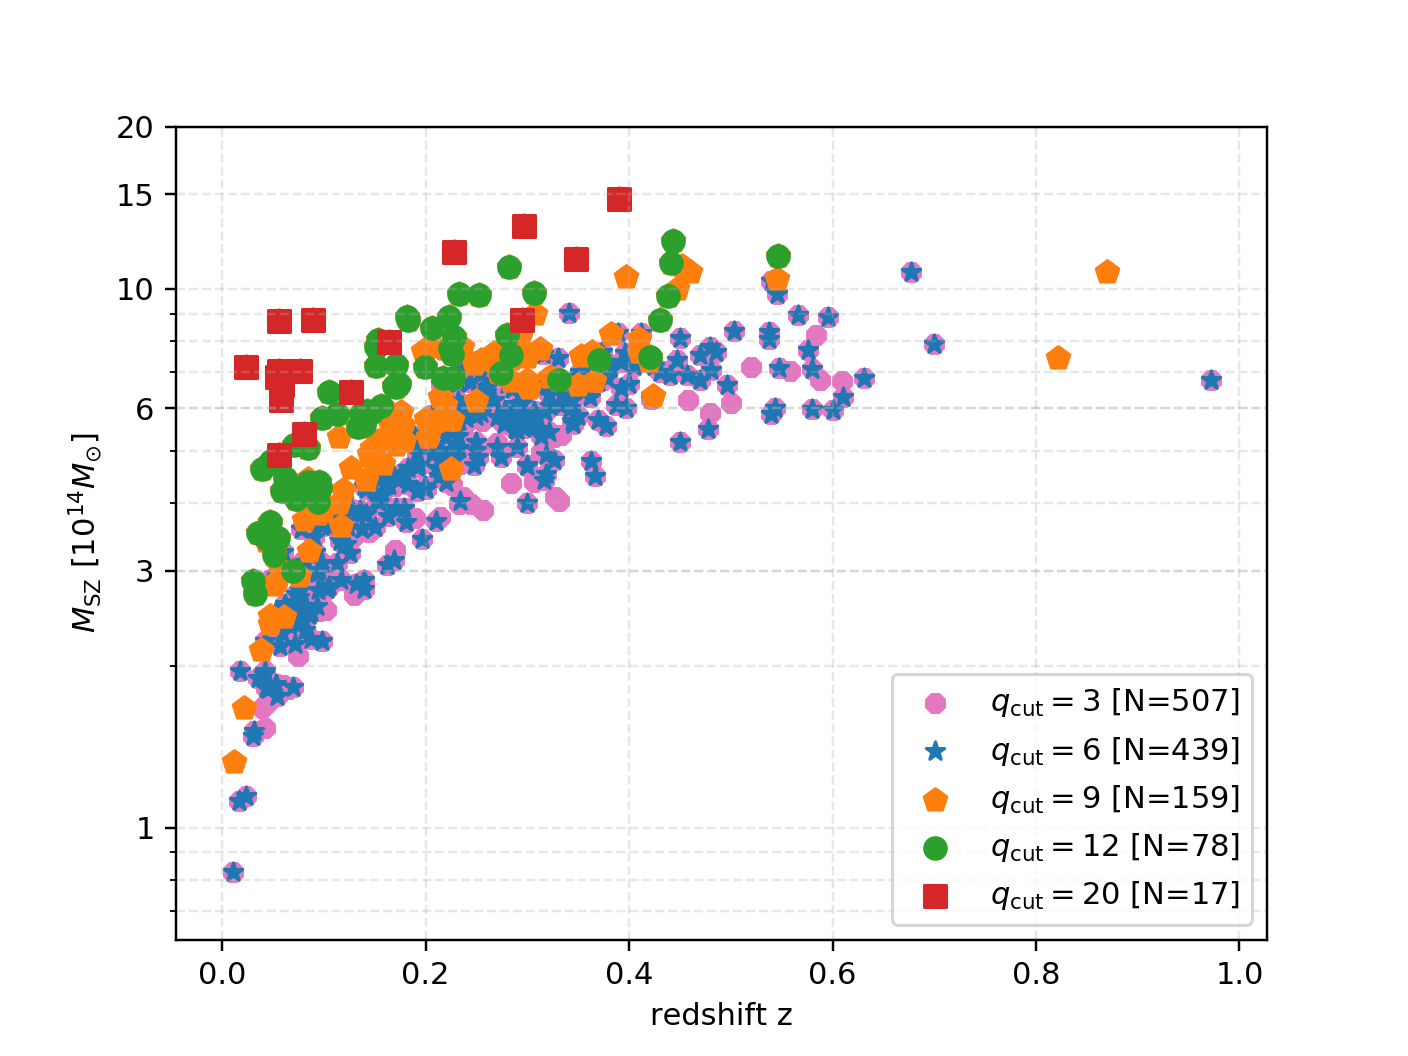

In [7]:
mmf3={}

for qcut in [3,6,9,12,20]:
    if qcut==0:
        mmf3[qcut]=ppd.get_mmf3_catalogue(zknown=False,snrthr=qcut,cosmo_flag=True)
    else:
        mmf3[qcut]=ppd.get_mmf3_catalogue(zknown=False,snrthr=qcut,cosmo_flag=True)
    
mt={} ; mt[3]="8" ; mt[6]="*" ; mt[9]="p" ; mt[12]="o" ; mt[20]="s"
ms={} ; ms[3]=40 ; ms[6]=40 ; ms[9]=60 ; ms[12]=50 ; ms[20]=50
mc={} ; mc[3]="tab:pink" ; mc[6]="tab:blue" ; mc[9]="tab:orange" ; mc[12]="tab:green" ; mc[20]="tab:red"
figure()
# qcut=0
# scatter(mmf3[qcut]["REDSHIFT"][mmf3[qcut]["REDSHIFT"]>=0],mmf3[qcut]["MSZ"][mmf3[qcut]["REDSHIFT"]>=0],marker="o",s=40,
#             label=r"$q_{\rm cut} \geq$" + str(qcut) + " [N=" + str(len(mmf3[qcut]["REDSHIFT"])) +"]",color="gray")
for qcut in [3,6,9,12,20]:
    scatter(mmf3[qcut]["REDSHIFT"][mmf3[qcut]["REDSHIFT"]>=0],mmf3[qcut]["MSZ"][mmf3[qcut]["REDSHIFT"]>=0],marker=mt[qcut],s=ms[qcut],
            label=r"$q_{\rm cut} =$" + str(qcut) + " [N=" + str(len(mmf3[qcut]["REDSHIFT"])) +"]",color=mc[qcut])
semilogy()
# title("COSMO=False")
xlabel("redshift z")
ylabel(r"$M_{\rm SZ}$" + " $[10^{14} M_{\odot}]$")
yticks([1,3,6,10,15,20],[1,3,6,10,15,20])
legend(loc=0)
grid(which="both",linestyle="dashed",alpha=0.3)
figname="../../results/yy_spec/sz_m_z_qcut_cosmo_true.pdf"
savefig(figname, bbox_inches="tight",dpi=200)
figname="../../results/yy_spec/sz_m_z_qcut_cosmo_true.jpeg"
savefig(figname, bbox_inches="tight",dpi=200)

In [395]:
tot=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_psmask/data/total_yy_spec.txt")
tot_g40=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal40_psmask/data/total_yy_spec.txt")
tot_g30=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal30_psmask/data/total_yy_spec.txt")
tot_g60=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal60_psmask/data/total_yy_spec.txt")

urc3=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc3_g40=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal40_psmask/data/unresolved_yy_spec.txt")
urc3_g30=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal30_psmask/data/unresolved_yy_spec.txt")
urc3_g60=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal60_psmask/data/unresolved_yy_spec.txt")
urc6=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc9=loadtxt("../../results/yy_spec/snr9_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc12=loadtxt("../../results/yy_spec/snr12_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc20=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc20_g40=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal40_psmask/data/unresolved_yy_spec.txt")
urc20_g60=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal60_psmask/data/unresolved_yy_spec.txt")

rc3=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc3_g40=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal40_psmask/data/resolved_yy_spec.txt")
rc3_g30=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal30_psmask/data/resolved_yy_spec.txt")
rc3_g60=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal60_psmask/data/resolved_yy_spec.txt")
rc6=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc9=loadtxt("../../results/yy_spec/snr9_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc12=loadtxt("../../results/yy_spec/snr12_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc20=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc20_g40=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal40_psmask/data/resolved_yy_spec.txt")
rc20_g30=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal30_psmask/data/resolved_yy_spec.txt")
rc20_g60=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal60_psmask/data/resolved_yy_spec.txt")

data=loadtxt("../../tempdata/diffuse-rotti++20_step_3_bf_szpowerspectrum.txt")

planck_yy=np.loadtxt(datapath + "/maps/bolliet2018.txt")

<IPython.core.display.Javascript object>


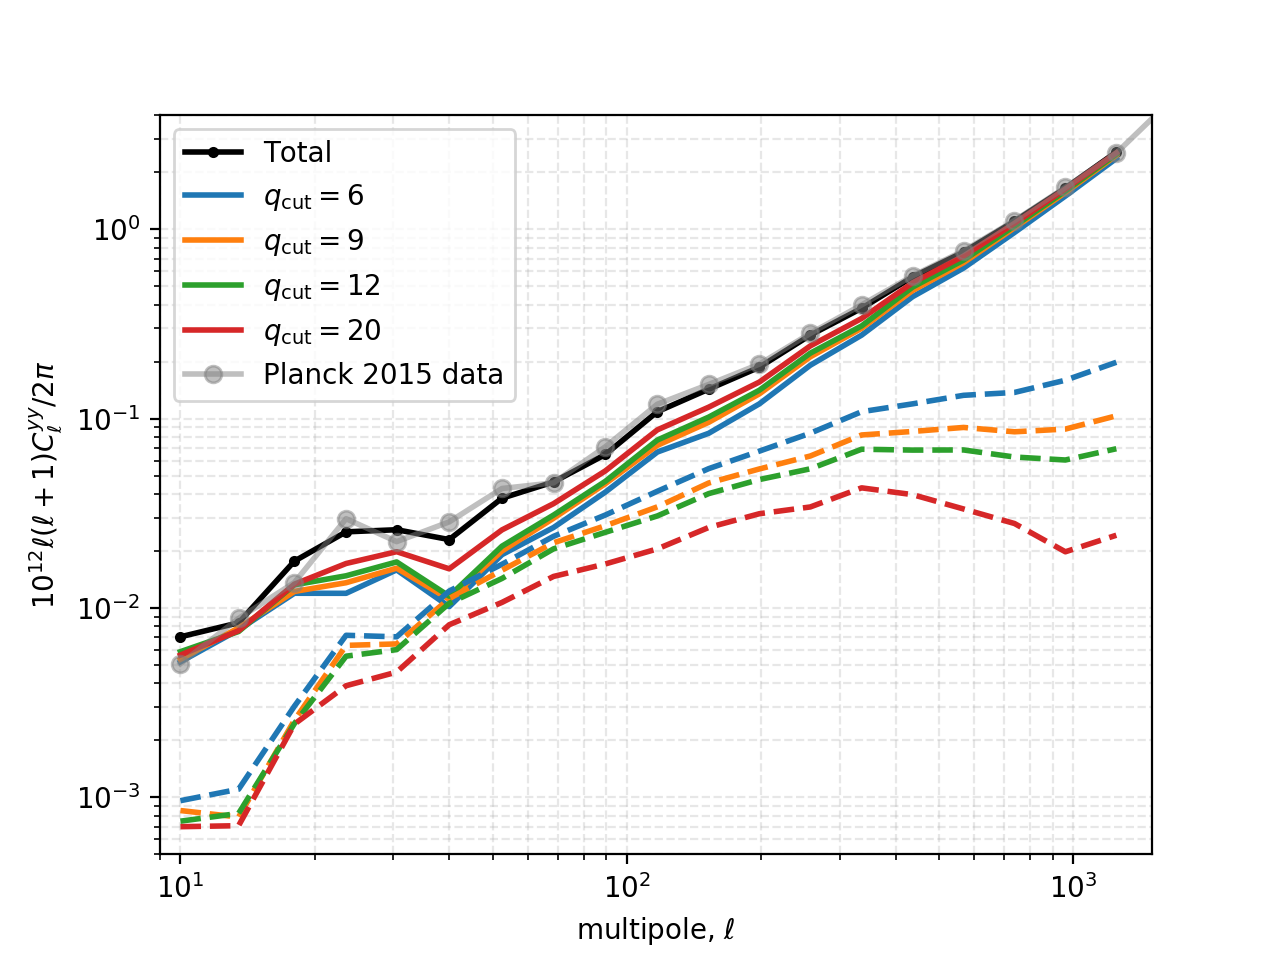

In [397]:
figure()
plot(tot[:,2],tot[:,3],"k.-",lw=2,label="Total")
plot(urc6[:,2],urc6[:,3],lw=2,c="tab:blue",label=r"$q_{\rm cut}=6$")
plot(urc9[:,2],urc9[:,3],lw=2,c="tab:orange",label=r"$q_{\rm cut}=9$")
plot(urc12[:,2],urc12[:,3],lw=2,c="tab:green",label=r"$q_{\rm cut}=12$")
plot(urc20[:,2],urc20[:,3],lw=2,c="tab:red",label=r"$q_{\rm cut}=20$")
# loglog()
# legend(loc=0)
# grid(which="both",alpha=0.3,linestyle="dashed")

# figure()
plot(rc6[:,2],rc6[:,3],"--",lw=2,c="tab:blue",label="")
plot(rc9[:,2],rc9[:,3],"--",lw=2,c="tab:orange",label="")
plot(rc12[:,2],rc12[:,3],"--",lw=2,c="tab:green",label="")
plot(rc20[:,2],rc20[:,3],"--",lw=2,c="tab:red",label="")
plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
loglog()
legend(loc=0)
grid(which="both",alpha=0.3,linestyle="dashed")
xlim(9,1500)
ylim(5e-4,4)
xlabel("multipole, $\ell$")
ylabel(r"$10^{12} \ell(\ell+1) C_{\ell}^{yy}/2 \pi$")
figname="../../results/yy_spec/all_qcut_yy_spec.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

<IPython.core.display.Javascript object>


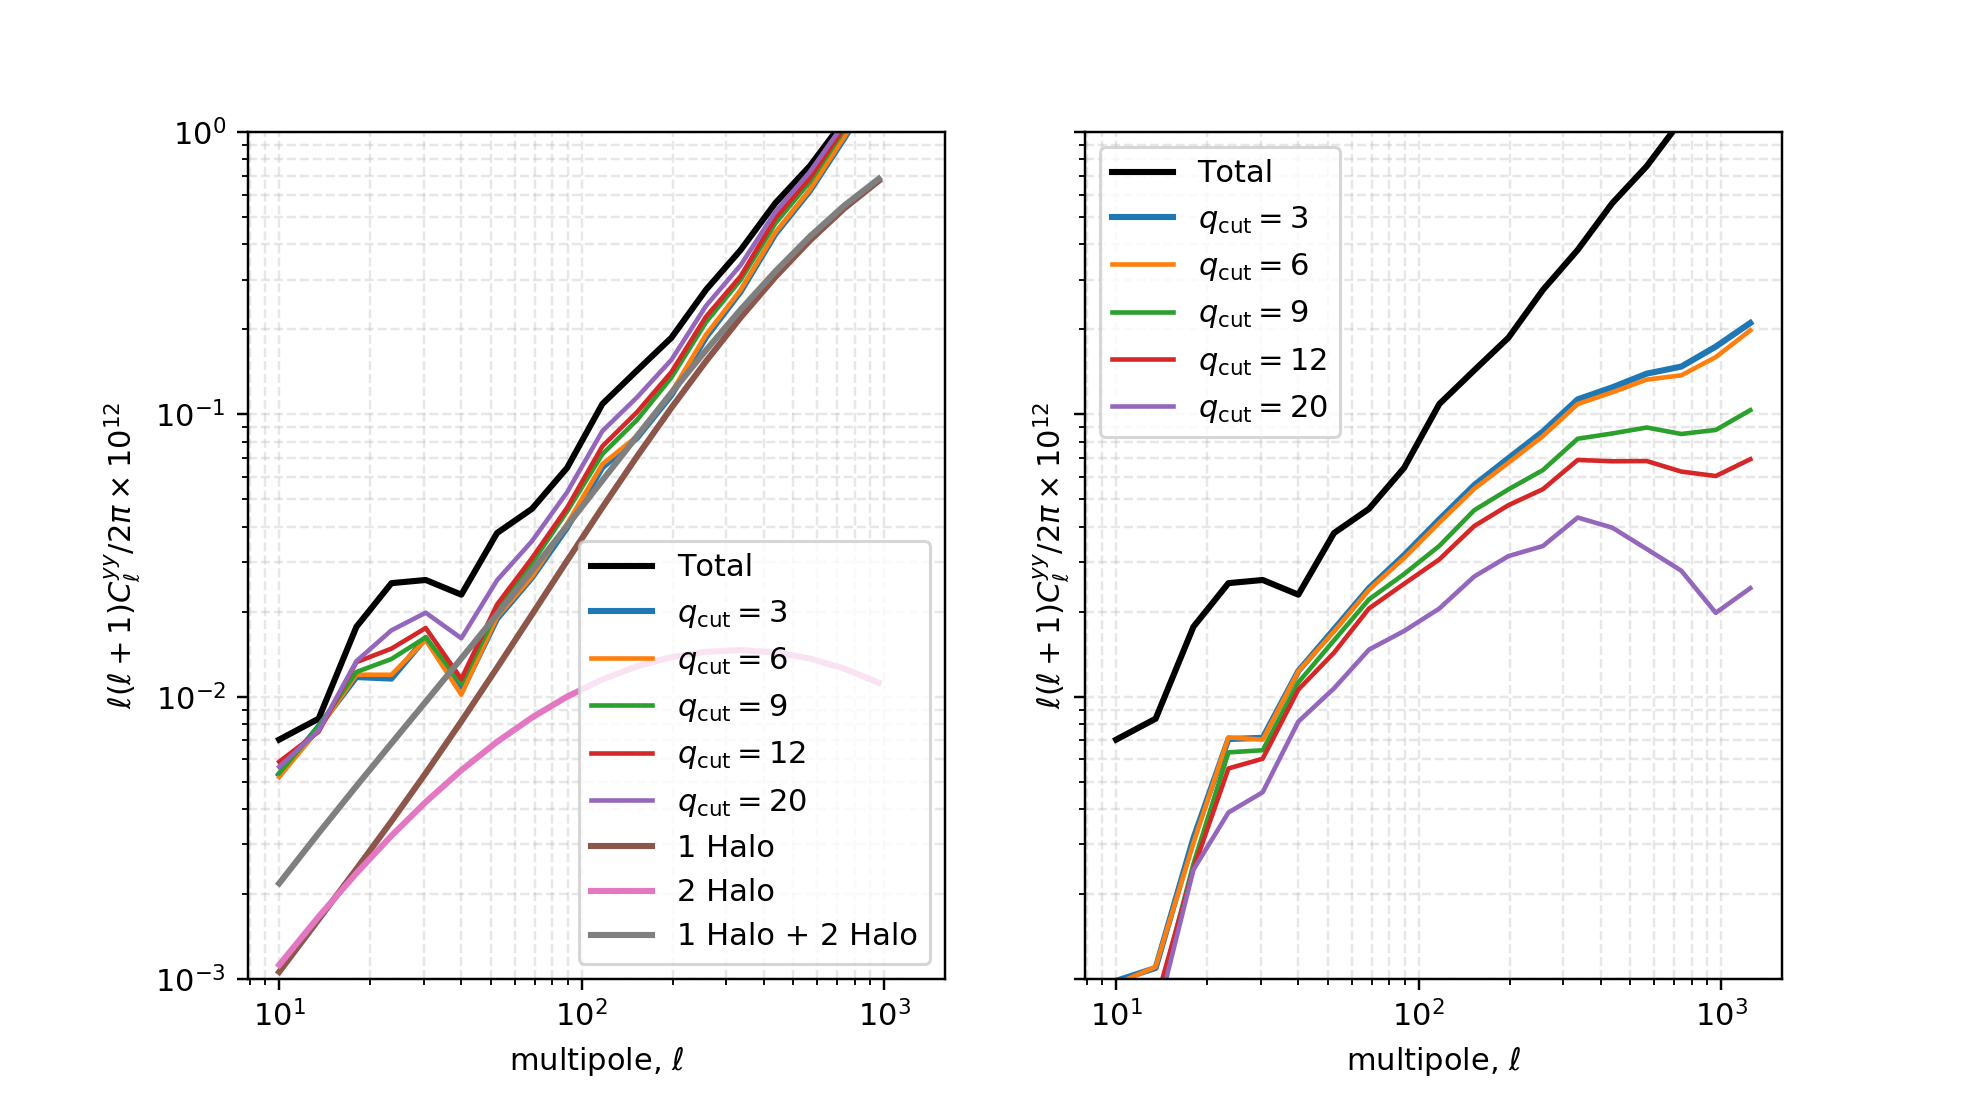

<IPython.core.display.Javascript object>


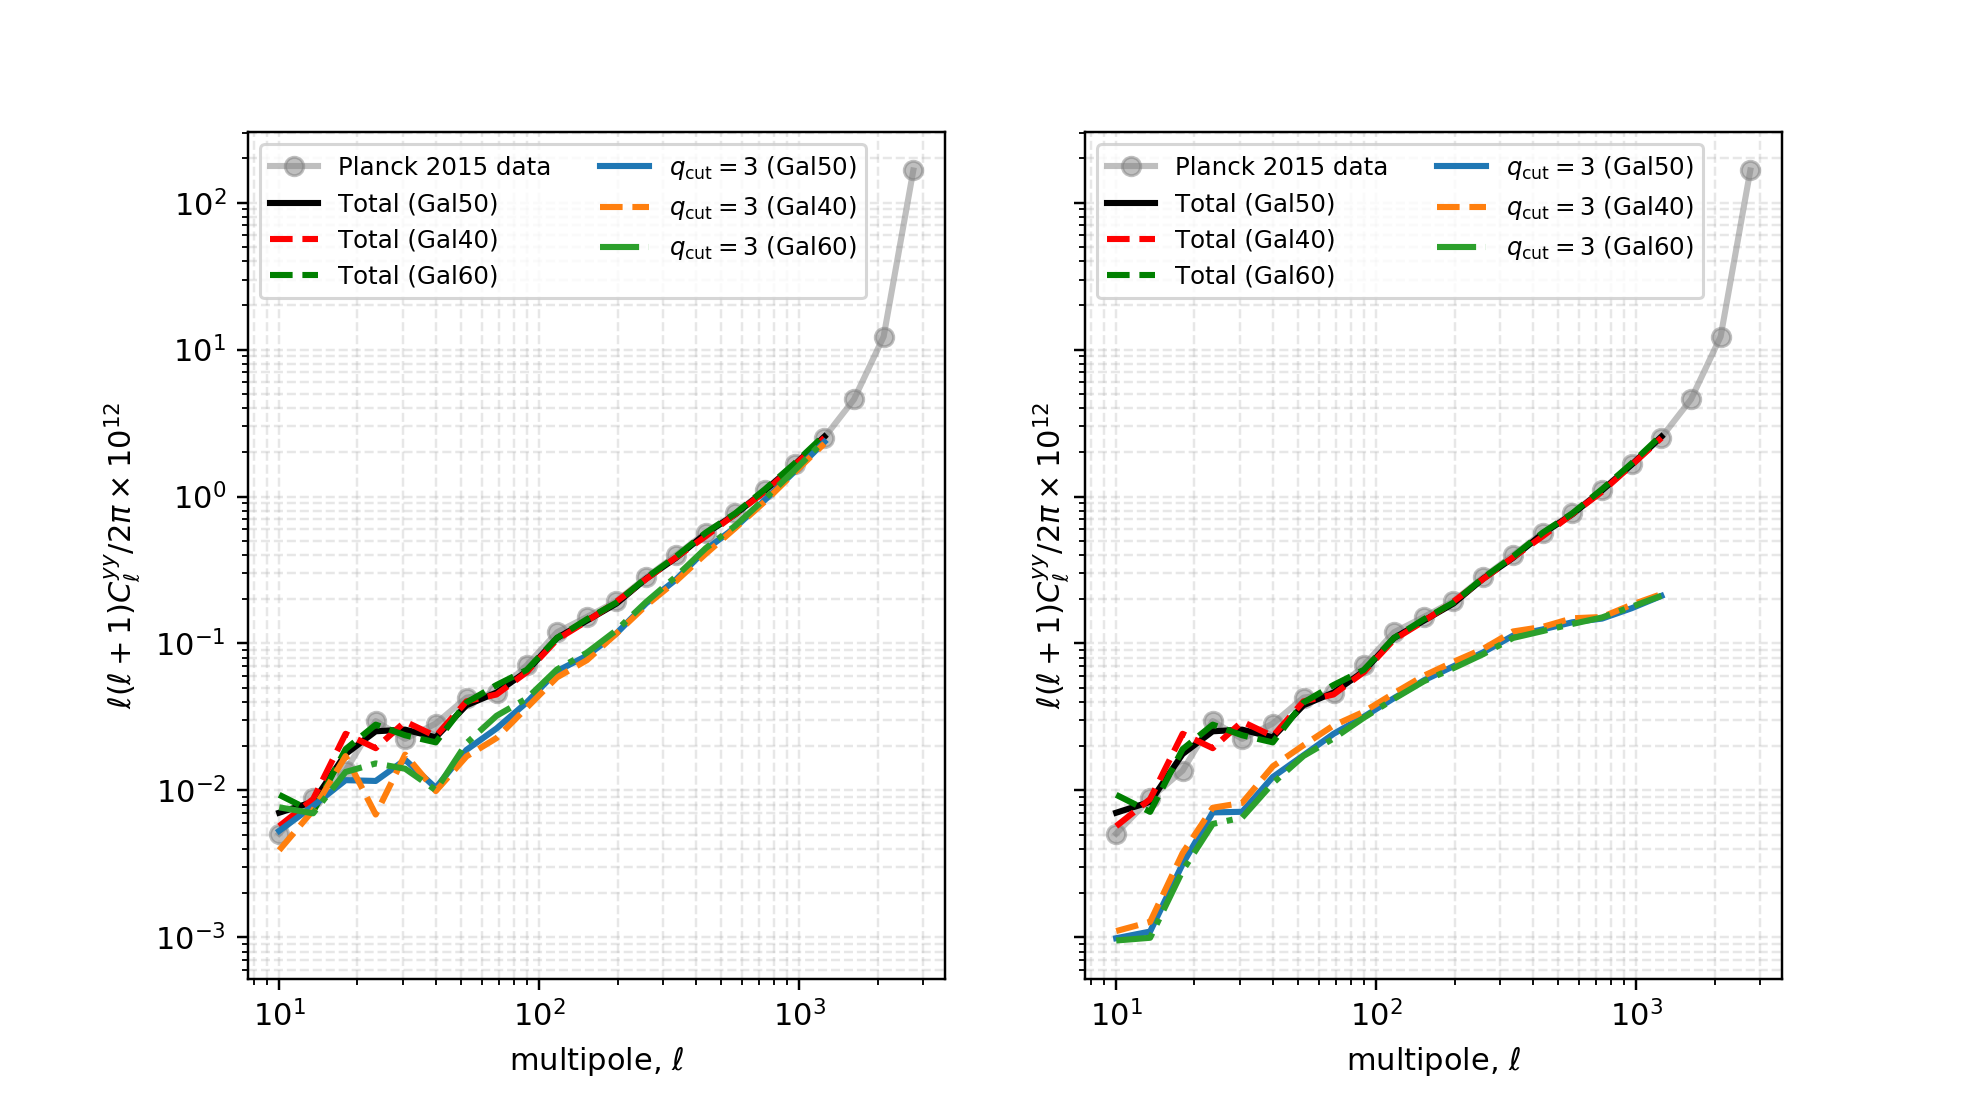

<IPython.core.display.Javascript object>


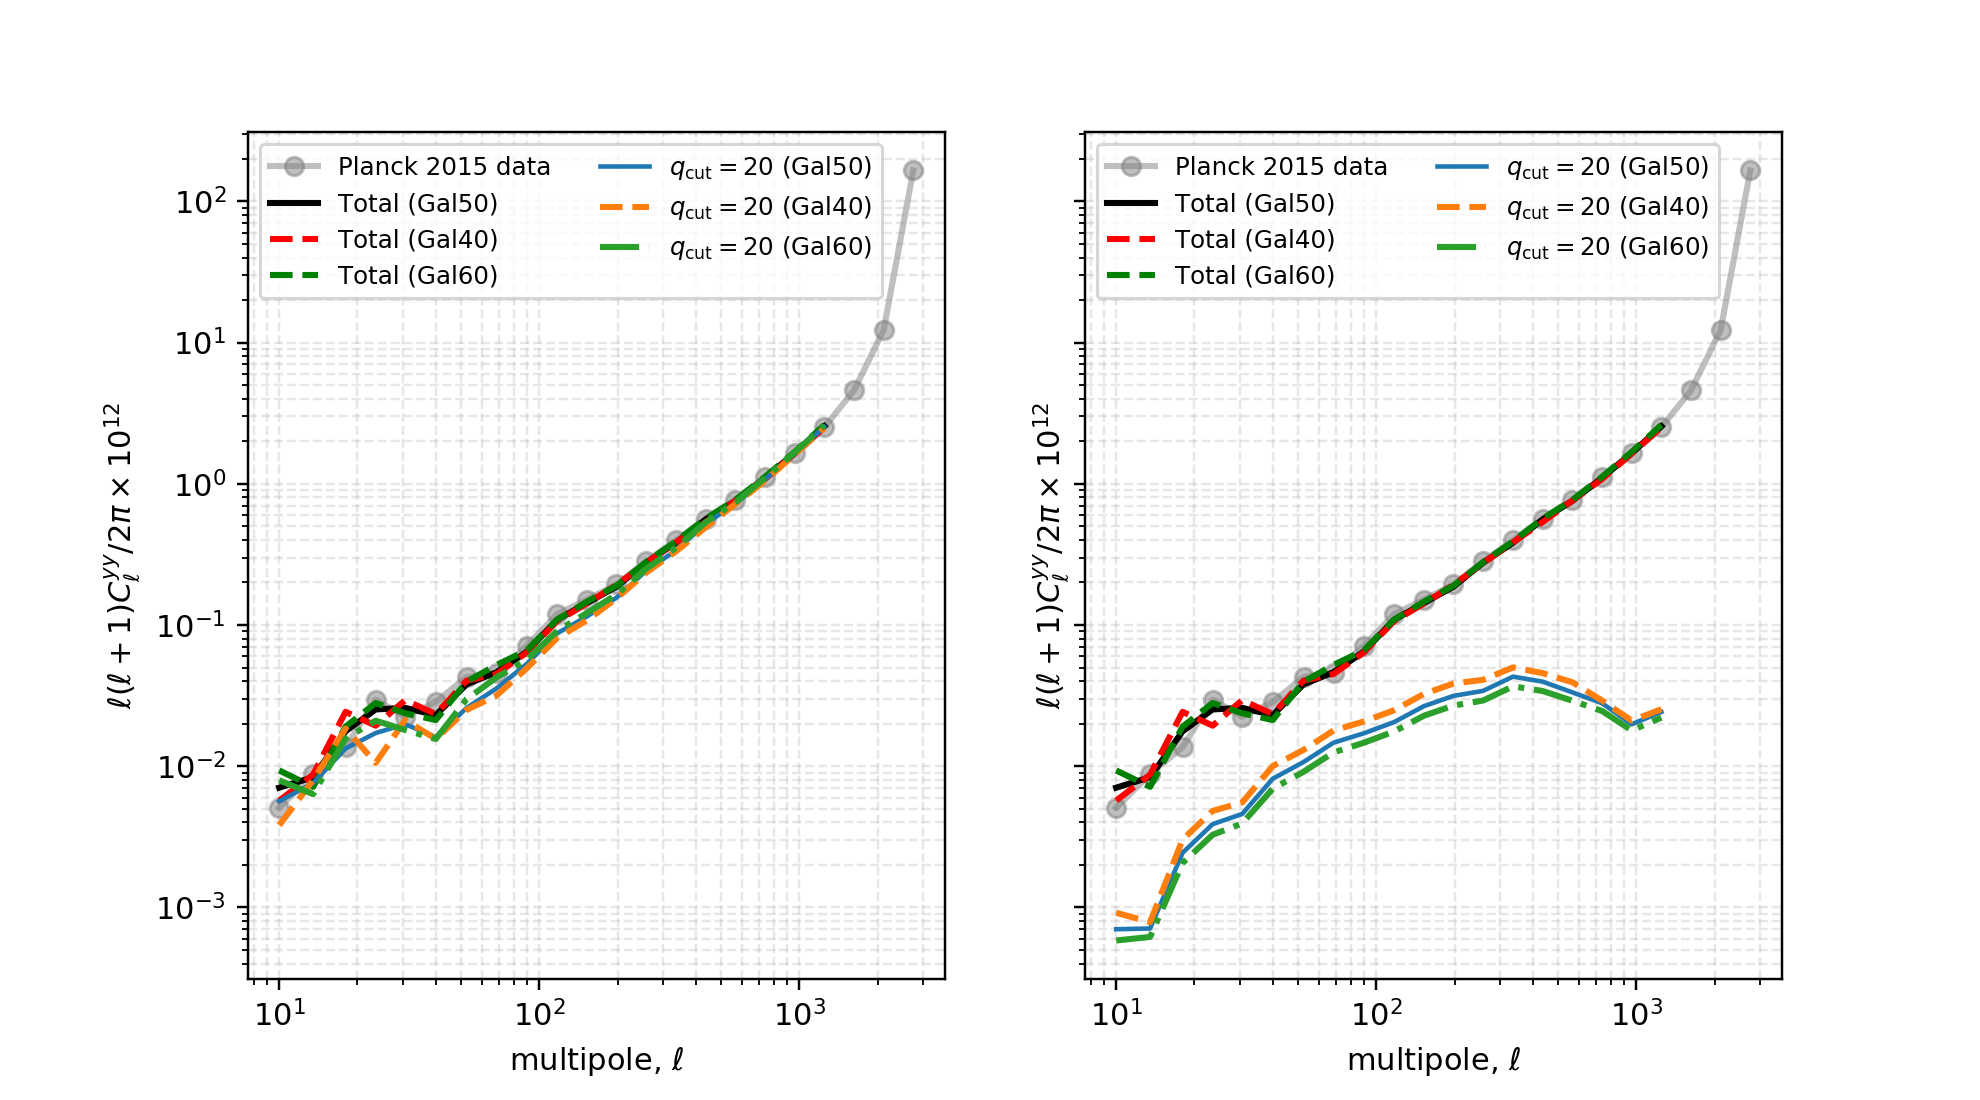

In [15]:
fig,ax=subplots(nrows=1,ncols=2,sharey=True,figsize=(9,5))
ax[0].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total")
ax[0].plot(urc3[:,2],urc3[:,3],lw=2,label=r"$q_{\rm cut}=3$")
ax[0].plot(urc6[:,2],urc6[:,3],label=r"$q_{\rm cut}=6$")
ax[0].plot(urc9[:,2],urc9[:,3],label=r"$q_{\rm cut}=9$")
ax[0].plot(urc12[:,2],urc12[:,3],label=r"$q_{\rm cut}=12$")
ax[0].plot(urc20[:,2],urc20[:,3],label=r"$q_{\rm cut}=20$")
ax[0].loglog()
ax[0].set_ylim(1e-3,1)
ax[0].grid(which="both",alpha=0.3,linestyle="dashed")
ax[0].set_xlabel("multipole, $\ell$")
ax[0].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")
ax[0].plot(data[:,0],data[:,1],lw=2,label="1 Halo")
ax[0].plot(data[:,0],data[:,6],lw=2,label="2 Halo")
ax[0].plot(data[:,0],data[:,6]+data[:,1],lw=2,label="1 Halo + 2 Halo")
ax[0].legend(loc=0)
ax[1].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total")
ax[1].plot(rc3[:,2],rc3[:,3],lw=2,label=r"$q_{\rm cut}=3$")
ax[1].plot(rc6[:,2],rc6[:,3],label=r"$q_{\rm cut}=6$")
ax[1].plot(rc9[:,2],rc9[:,3],label=r"$q_{\rm cut}=9$")
ax[1].plot(rc12[:,2],rc12[:,3],label=r"$q_{\rm cut}=12$")
ax[1].plot(rc20[:,2],rc20[:,3],label=r"$q_{\rm cut}=20$")
ax[1].loglog()
ax[1].grid(which="both",alpha=0.3,linestyle="dashed")
ax[1].legend(loc=0)
ax[1].set_xlabel("multipole, $\ell$")
ax[1].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")

figname="../../results/yy_spec/all_qcut_gal50.pdf"
savefig(figname, bbox_inches="tight",dpi=200)


fig,ax=subplots(nrows=1,ncols=2,sharey=True,figsize=(9,5))
# figure()
ax[0].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[0].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
# ax[0].plot(tot_g30[:,2],tot_g30[:,3],"--",c="b",lw=2,label="Total (Gal30)")
ax[0].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[0].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[0].plot(urc3[:,2],urc3[:,3],lw=2,label=r"$q_{\rm cut}=3$ (Gal50)")
ax[0].plot(urc3_g40[:,2],urc3_g40[:,3],"--",lw=2,label=r"$q_{\rm cut}=3$ (Gal40)")
ax[0].plot(urc3_g60[:,2],urc3_g60[:,3],"-.",lw=2,label=r"$q_{\rm cut}=3$ (Gal60)")
ax[0].loglog()
ax[0].grid(which="both",alpha=0.3,linestyle="dashed")
ax[0].legend(loc=0,ncol=2,fontsize=8)
# ax[0].set_xlim(2,200)
ax[0].set_xlabel("multipole, $\ell$")
ax[0].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")

ax[1].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[1].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
ax[1].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[1].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[1].plot(rc3[:,2],rc3[:,3],lw=2,label=r"$q_{\rm cut}=3$ (Gal50)")
ax[1].plot(rc3_g40[:,2],rc3_g40[:,3],"--",lw=2,label=r"$q_{\rm cut}=3$ (Gal40)")
ax[1].plot(rc3_g60[:,2],rc3_g60[:,3],"-.",lw=2,label=r"$q_{\rm cut}=3$ (Gal60)")
ax[1].loglog()
ax[1].grid(which="both",alpha=0.3,linestyle="dashed")
ax[1].legend(loc=0,ncol=2,fontsize=8)
# ax[1].set_xlim(2,200)
ax[1].set_xlabel("multipole, $\ell$")
ax[1].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")
figname="../../results/yy_spec/qcut3_variable_mask.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

fig,ax=subplots(nrows=1,ncols=2,sharey=True,figsize=(9,5))
# figure()
ax[0].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[0].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
ax[0].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[0].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[0].plot(urc20[:,2],urc20[:,3],label=r"$q_{\rm cut}=20$ (Gal50)")
ax[0].plot(urc20_g40[:,2],urc20_g40[:,3],"--",lw=2,label=r"$q_{\rm cut}=20$ (Gal40)")
ax[0].plot(urc20_g60[:,2],urc20_g60[:,3],"-.",lw=2,label=r"$q_{\rm cut}=20$ (Gal60)")
ax[0].loglog()
ax[0].grid(which="both",alpha=0.3,linestyle="dashed")
ax[0].legend(loc=0,ncol=2,fontsize=8)
ax[0].set_xlabel("multipole, $\ell$")
ax[0].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")

ax[1].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[1].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
ax[1].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[1].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[1].plot(rc20[:,2],rc20[:,3],label=r"$q_{\rm cut}=20$ (Gal50)")
ax[1].plot(rc20_g40[:,2],rc20_g40[:,3],'--',lw=2,label=r"$q_{\rm cut}=20$ (Gal40)")
ax[1].plot(rc20_g60[:,2],rc20_g60[:,3],'-.',lw=2,label=r"$q_{\rm cut}=20$ (Gal60)")
ax[1].loglog()
ax[1].grid(which="both",alpha=0.3,linestyle="dashed")
ax[1].legend(loc=0,ncol=2,fontsize=8)
# ax[1].set_xlim(2,200)
ax[1].set_xlabel("multipole, $\ell$")
ax[1].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")
figname="../../results/yy_spec/qcut20_variable_mask.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

# Fsky table

In [28]:
fskytable=collections.OrderedDict()
fskytable[r"$q_{\rm cut}$"]=[3,6,9,12,20]
fskytable["uRC (\%)"]=np.array([0.343575, 0.344612, 0.349003, 0.350654, 0.352572])*100
fskytable["RC (\%)"]=np.array([0.012225, 0.011039,0.005965, 0.004092, 0.001958 ])*100

fskypd=pd.DataFrame(fskytable)

In [33]:
fskypd.to_latex("../../results/yy_spec/fsky.tex",column_format="ccc",multirow=True,index=False,escape=False,float_format="%.2f")

# Dependence on radius of cluster mask

In [2]:
tot5=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/total_yy_spec.txt")
rc5=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
urc5=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")

tot3=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_3theta_psmask/data/total_yy_spec.txt")
rc3=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_3theta_psmask/data/resolved_yy_spec.txt")
urc3=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_3theta_psmask/data/unresolved_yy_spec.txt")

tot10=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_10theta_psmask/data/total_yy_spec.txt")
rc10=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_10theta_psmask/data/resolved_yy_spec.txt")
urc10=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_10theta_psmask/data/unresolved_yy_spec.txt")

<IPython.core.display.Javascript object>


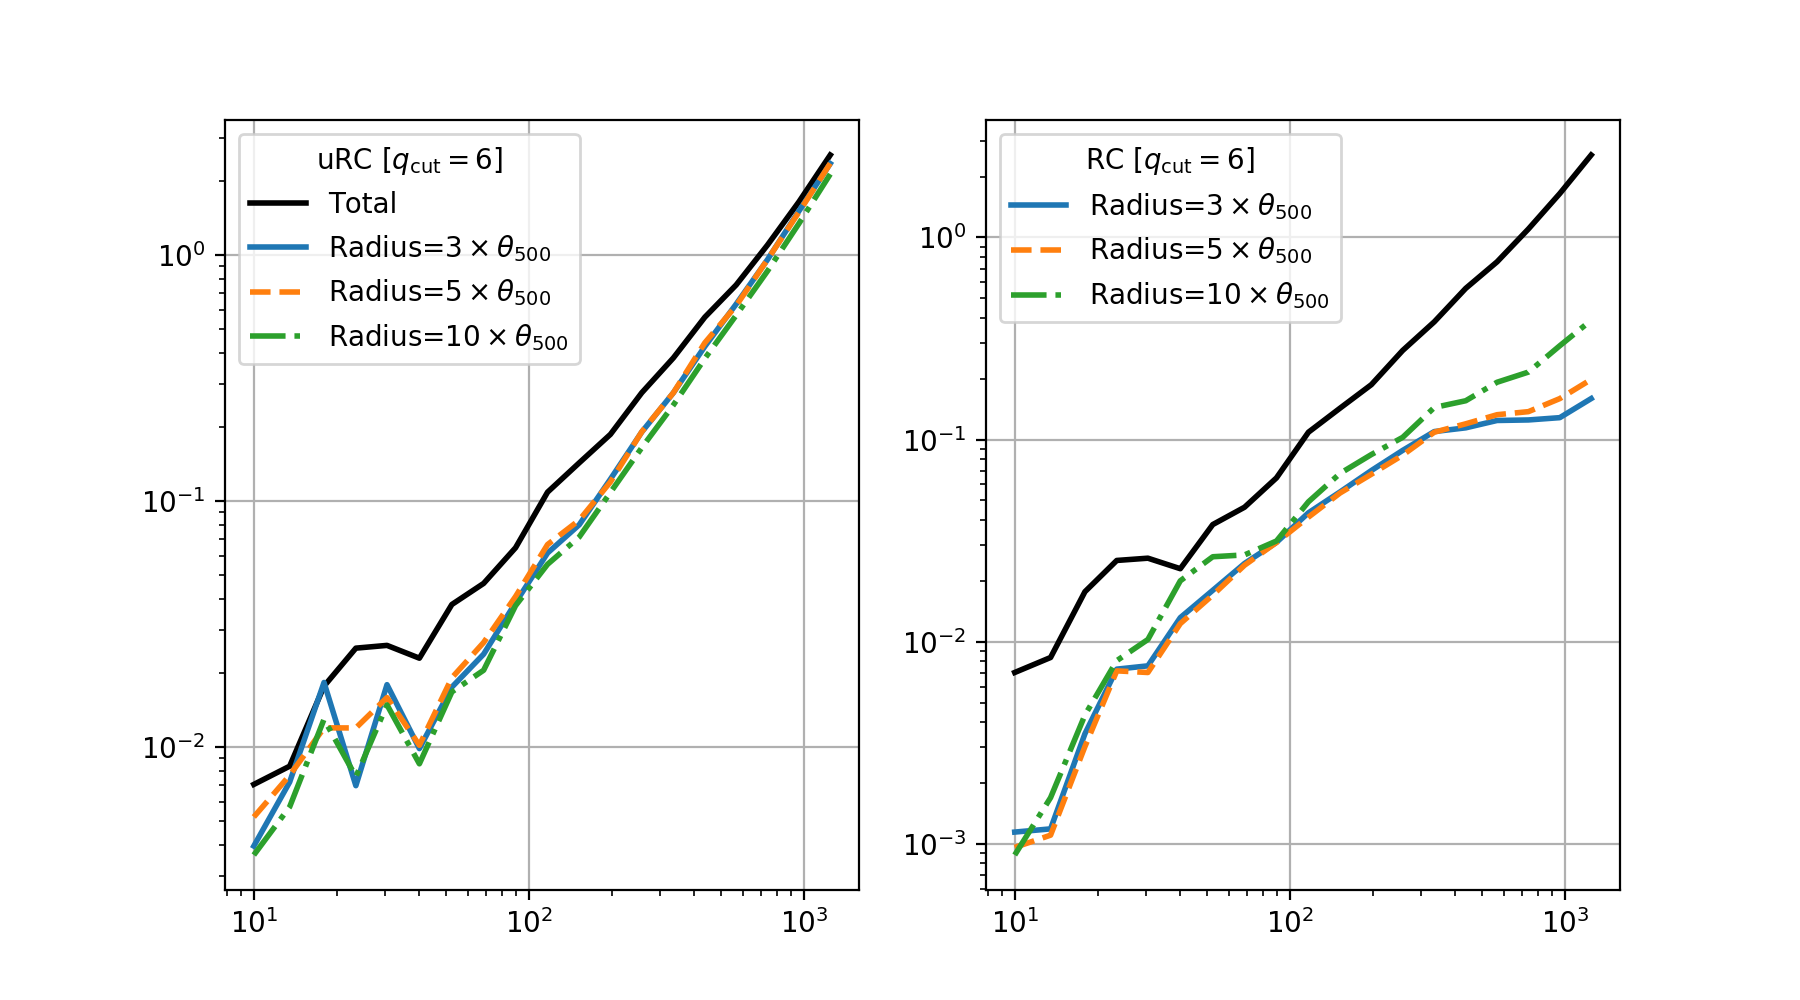

In [3]:
fig, ax=subplots(nrows=1,ncols=2,figsize=(9,5))
ax[0].plot(tot5[:,2],tot5[:,3],"k-",lw=2,label="Total")
ax[0].plot(urc3[:,2],urc3[:,3],"-",lw=2,label=r"Radius=$3\times \theta_{500}$")
ax[0].plot(urc5[:,2],urc5[:,3],"--",lw=2,label=r"Radius=$5\times \theta_{500}$")
ax[0].plot(urc10[:,2],urc10[:,3],"-.",lw=2,label=r"Radius=$10\times \theta_{500}$")
ax[0].grid()
ax[0].loglog()
ax[0].legend(loc=0,title=r"uRC [$q_{\rm cut}=6$]")

ax[1].plot(tot5[:,2],tot5[:,3],"k-",lw=2)
ax[1].plot(rc3[:,2],rc3[:,3],"-",lw=2,label=r"Radius=$3\times \theta_{500}$")
ax[1].plot(rc5[:,2],rc5[:,3],"--",lw=2,label=r"Radius=$5\times \theta_{500}$")
ax[1].plot(rc10[:,2],rc10[:,3],"-.",lw=2,label=r"Radius=$10\times \theta_{500}$")
ax[1].grid()
ax[1].loglog()
ax[1].legend(loc=0,title=r"RC [$q_{\rm cut}=6$]")

figname="../../results/yy_spec/cluster_mask_size_dependence.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

# 1 Halo 2 Halo + error

<IPython.core.display.Javascript object>


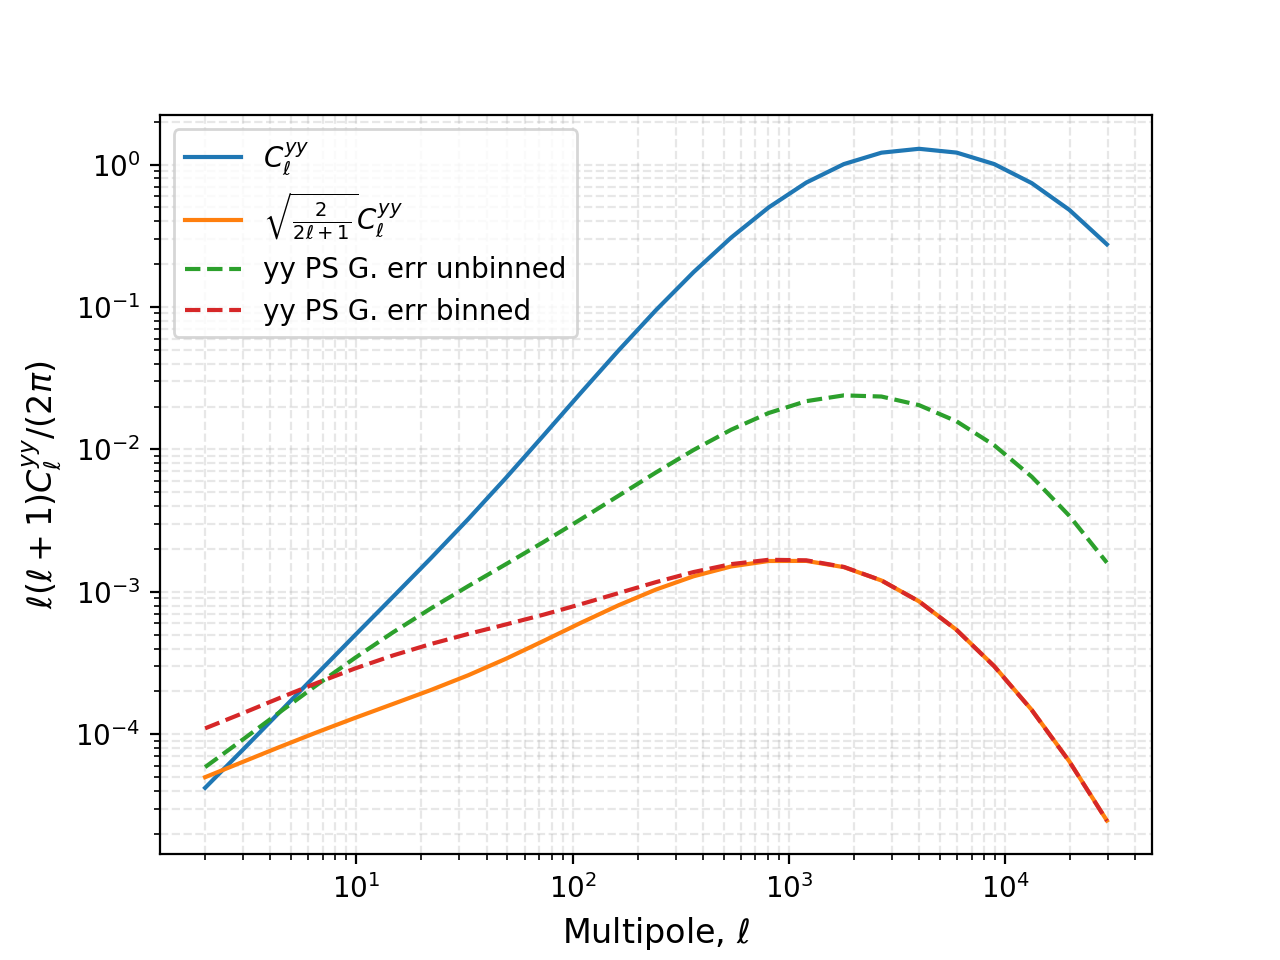

In [3]:
data=loadtxt("../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_diffuse_snr_6.txt")
ell=data[:,0]
fl=ell*(ell+1)/(2.*pi)
clyy=data[:,1]/fl
clyy_var=(clyy**2)*(2./(2.*ell+1))
clyy_var_ub=data[:,2]
clyy_var_b=data[:,4]
dl=ell*0.4
fsky=0.354430
nmode_correction=dl*fsky
figure()
plot(ell,fl*clyy,label=r"$C_{\ell}^{yy}$")
plot(ell,fl*np.sqrt(clyy_var)/sqrt(nmode_correction),"-",label=r"$\sqrt{\frac{2}{2 \ell+1}}C_{\ell}^{yy}$")
plot(ell,fl*np.sqrt(clyy_var_ub),"--",label="yy PS G. err unbinned")
plot(ell,fl*np.sqrt(clyy_var_b),"--",label="yy PS G. err binned")

loglog()
legend(loc=0)
grid(which="both",linestyle="dashed",alpha=0.3)
ylabel(r"$\ell(\ell+1)C_{\ell}^{yy}/(2 \pi)$",fontsize=12)
xlabel(r"Multipole, $\ell$",fontsize=12)

savefig("err_fig.jpeg",bbox_inches="tight",dpi=100)

In [6]:
def return_planck_ell_dl():
    planckyy=np.loadtxt(datapath + "/maps/planck2015_yy_ps.txt")
    bmin=planckyy[:,3]
    bmax=planckyy[:,4]
    ell=[]
    dl=[]
    for i in range(len(bmin)):
        ll=np.linspace(bmin[i],bmax[i],bmax[i]-bmin[i]+1)
        ell=ell + [np.mean(ll)]
        dl = dl + [len(ll)]
    return np.array(ell),np.array(dl)

ellp,dlp=return_planck_ell_dl()

def return_binned_spec(data,fsky,ellp=[],dlp=[],Tll_fsky=1):
    if ellp==[]:
        ellp=data[:,0]
    if dlp==[]:
        dlp=data[:,0]*0.4
        
    clyy_plb={}
    
    ell=data[:,0] ; fl=ell*(ell+1)/(2.*pi)
    clyy_plb["ell"]=ellp
    clyy_plb["fl"]=ellp*(ellp+1.)/(2.*pi)
    
    # 1 Halo term
    clyy=data[:,1]/fl
    clyy_plb["1h"]=10.**np.interp(np.log10(ellp),np.log10(ell),np.log10(clyy))
    
    #  2 halo term
    clyy=data[:,6]/fl
    clyy_plb["2h"]=10.**np.interp(np.log10(ellp),np.log10(ell),np.log10(clyy))
    
    # 1 halo + 2 halo
    clyy_plb["1h2h"]=clyy_plb["1h"] + clyy_plb["2h"]
    
    # 1 halo Gaussian error
    clyy_var=(clyy**2)*(2./(2.*ell+1))
    clyy_plb["1h_Gerr"]=clyy_plb["1h"]*np.sqrt(2./((2.*ellp+1)*dlp*fsky))
    
    # Total Gaussian error
    clyy_plb["1h2h_Gerr"]=(clyy_plb["1h"]+clyy_plb["2h"])*np.sqrt(2./((2.*ellp+1)*dlp*fsky))
    
    # Trispectrum diagonal error
    Tll=data[:,3]
    clyy_plb["1h_Terr"]=np.sqrt(10.**np.interp(np.log10(ellp),np.log10(ell),np.log10(Tll/Tll_fsky)))
    
    # Total error
    clyy_plb["tot_err"]=np.sqrt(clyy_plb["1h2h_Gerr"]**2. + clyy_plb["1h_Terr"]**2.)
    return clyy_plb

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


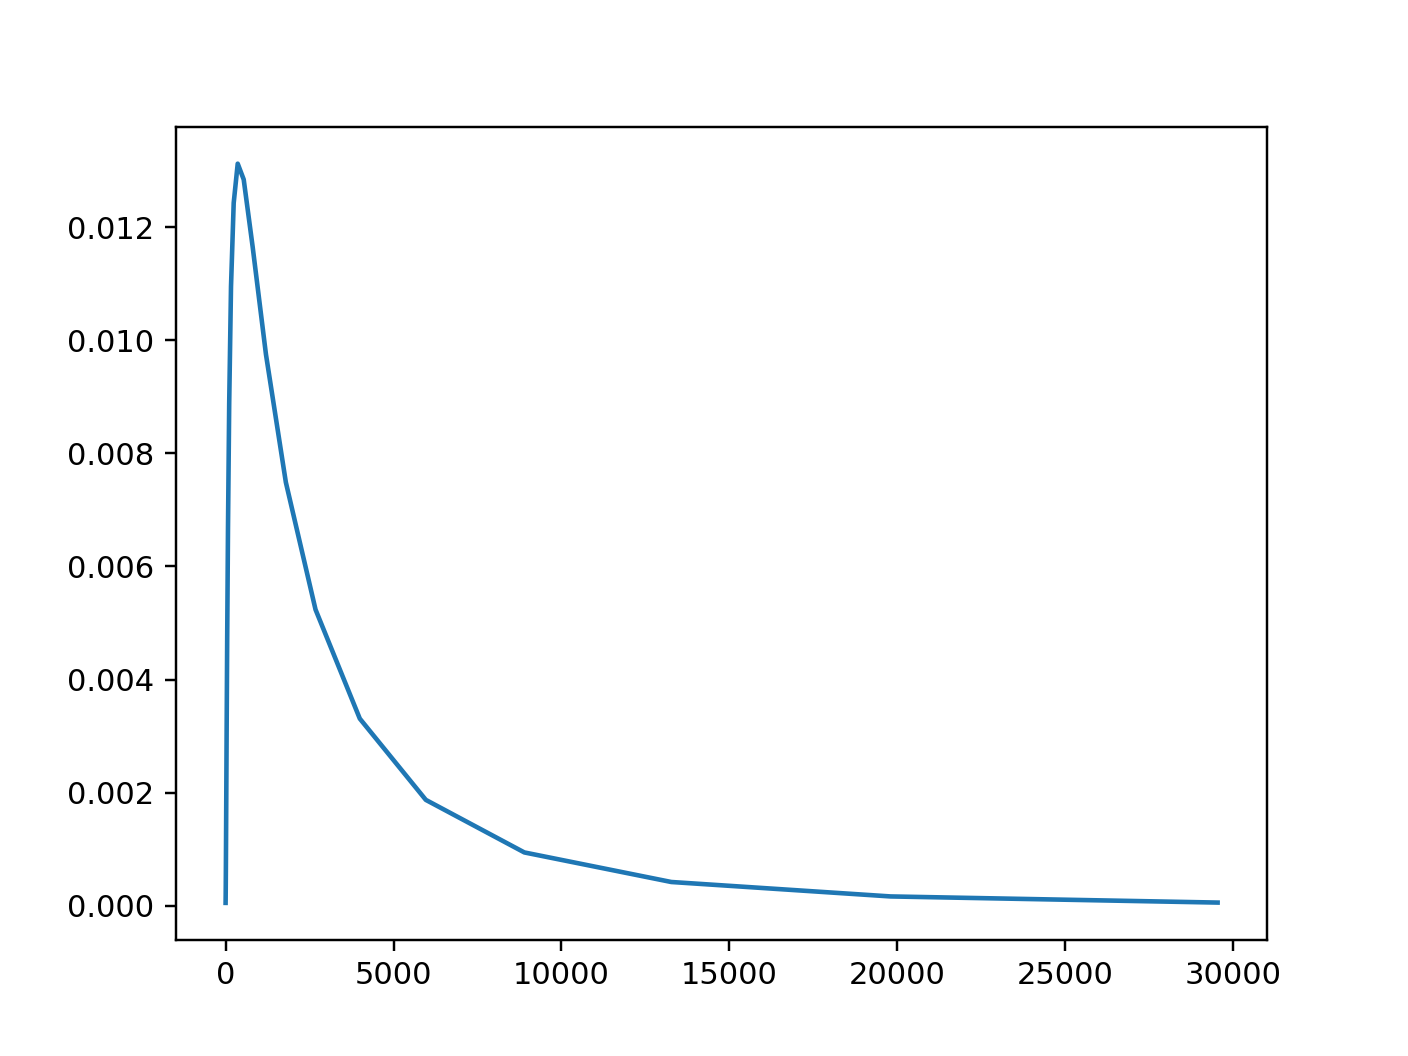

KeyError: 'tot'

In [7]:
ell=data[:,0] 
Tll=data[:,3]
temp=10.**np.interp(np.log10(ellp),np.log10(ell),np.log10(Tll))
figure()

plot(ell,data[:,6])
plot(ellp,clyy["tot"]["2h"]*clyy["tot"]["fl"])
loglog()

In [8]:
tot=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/total_yy_spec.txt")
q6urc=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
q6rc=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")

fsky={}
fsky["tot"]=0.35443
fsky["urc"]=0.344612
fsky["rc"]=0.35443

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


<IPython.core.display.Javascript object>


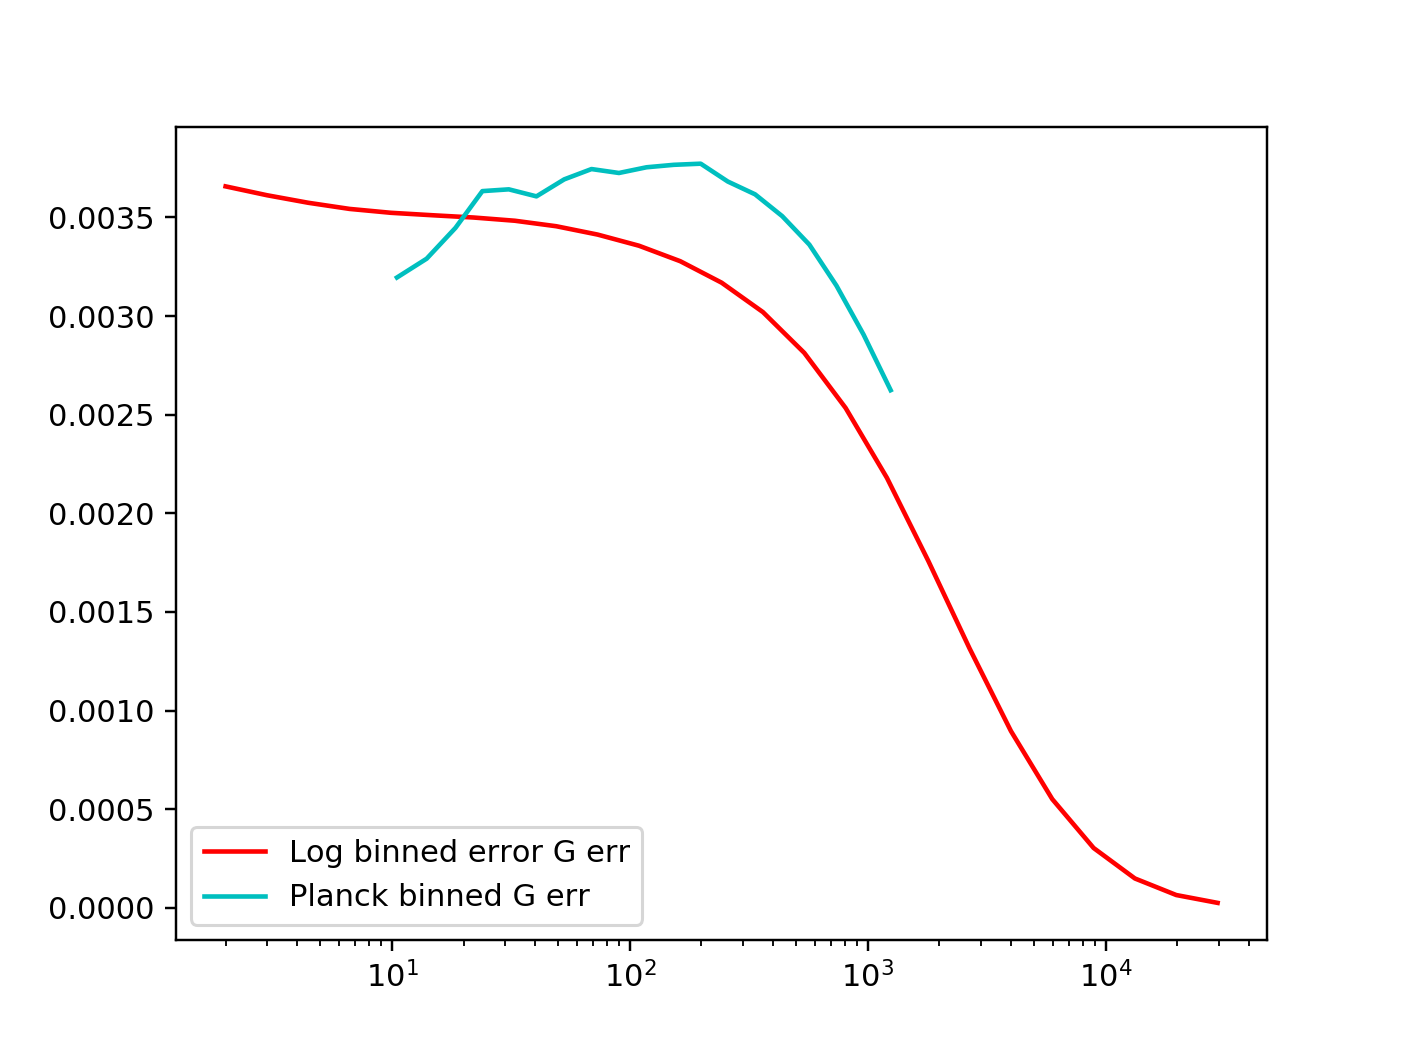

In [9]:
data=loadtxt("../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_total.txt")
clyy_tot=return_binned_spec(data,fsky["tot"],ellp,dlp)

ell=data[:,0]
fl=ell*(ell+1)/(2.*pi)
clyy=data[:,1]/fl
clyy_var=(clyy**2)*(2./(2.*ell+1))
clyy_var_ub=data[:,2]
clyy_var_b=data[:,4]
clyy_T=data[:,3]
clyy_tot_err=data[:,5]
dl=ell*0.4
nmode_correction=dl*fsky["tot"]

figure()
# plot(clyy_tot["ell"],clyy_tot["fl"]*clyy_tot["1h"],"k-.")
# plot(ell,fl*clyy,"k-",label="yy PS")
# plot(ell,fl*np.sqrt(clyy_var/fsky["tot"]),"g-",label="Unbinned error")
plot(ell,fl*np.sqrt(clyy_var_b),"r-",label="Log binned error G err")
plot(clyy_tot["ell"],clyy_tot["fl"]*clyy_tot["1h_Gerr"],"c-",label="Planck binned G err")
# loglog()
legend(loc=0)
semilogx()
figname="../../results/yy_spec/binning_comparison.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

# figure()
# plot(clyy_tot["ell"],clyy_tot["fl"]*clyy_tot["1h"],"k-.")
# plot(ell,clyy_tot_err,"k-")
# plot(ell,fl*np.sqrt(clyy_var_b+clyy_T),"r--")
# plot(clyy_tot["ell"],clyy_tot["fl"]*clyy_tot["tot_err"],"g-.")
# # plot(ell,fl*np.sqrt(clyy_T),"c--")
# loglog()

# figure()
# plot(ell,data[:,5],"k-")
# plot(clyy_tot["ell"],clyy_tot["fl"]*clyy_tot["2h"],"g-.")
# plot(clyy_tot["ell"],clyy_tot["fl"]*clyy_tot["tot_err"],"r-.")

# loglog()
# figure()
# plot(data[:,0],data[:,5]**2.,"g-")
# plot(data[:,0],data[:,3]/(data[:,0]*0.4*fsky["tot"]),"k--",label="T")
# plot(data[:,0],data[:,2],"k-",label="G")
# plot(data[:,0],data[:,2]+data[:,3],"m-")
# loglog()

In [10]:
tot=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/total_yy_spec.txt")
q6urc=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
q6rc=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")

fsky={}
fsky["tot"]=0.35443
fsky["urc"]=0.344612
fsky["rc"]=0.35443

In [11]:
clyy={}
# data=loadtxt("../../tempdata/rotti_20_1_6_50/diffuse-rotti_20-snr6-2h_step_5_bf_szpowerspectrum_large_ell_the_best_cosmologically_consistent_model.txt")
# clyy["urc6_true"]=return_binned_spec(data,fsky["urc"],ellp,dlp,Tll_fsky=fsky["urc"])
data=loadtxt("../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_diffuse_snr_6.txt")
clyy["urc6"]=return_binned_spec(data,fsky["urc"],ellp,dlp)
# clyy["urc6"]["1h"]=clyy["urc6_true"]["1h"]
# clyy["urc6"]["2h"]=clyy["urc6_true"]["2h"]
# clyy["urc6"]["1h2h"]=clyy["urc6_true"]["1h2h"]
data=loadtxt("../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_resolved_snr_6.txt")
clyy["rc6"]=return_binned_spec(data,fsky["rc"],ellp,dlp)
data=loadtxt("../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_total.txt")
clyy["tot"]=return_binned_spec(data,fsky["tot"],ellp,dlp)

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


# 2 halo detectability

<IPython.core.display.Javascript object>


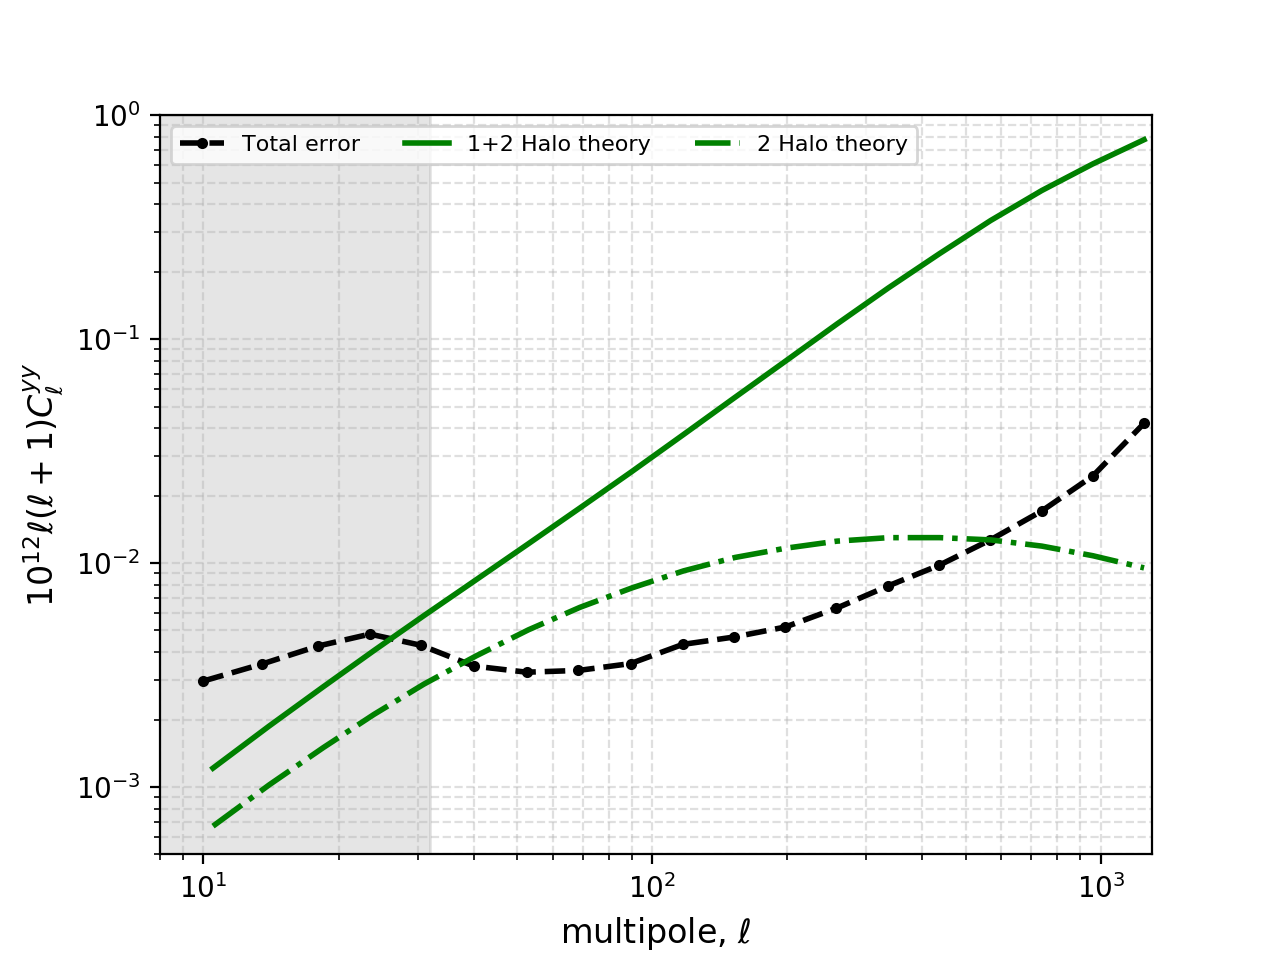

In [10]:
wdata="urc6"
pldata=np.copy(q6urc)

figure()
# plot(pldata[:,2],pldata[:,3],"k.-",lw=2,label=r"Planck uRC")
plot(pldata[:,2],np.sqrt(pldata[:,4]**2. + (clyy[wdata]["fl"]*clyy[wdata]["1h_Terr"])**2.),"k.--",lw=2,label=r"Total error")

color="g" ; 
fl=clyy[wdata]["fl"]
plot(clyy[wdata]["ell"],fl*clyy[wdata]["1h2h"],"-",c=color,lw=2, label=r"1+2 Halo theory")
# plot(clyy[wdata]["ell"],fl*clyy[wdata]["1h"],"--",c=color,lw=2, label=r"1 Halo theory")
plot(clyy[wdata]["ell"],fl*clyy[wdata]["2h"],"-.",c=color,lw=2, label=r"2 Halo theory")

# plot(pldata[:,2],pldata[:,4],"m--",lw=2,label=r"Planck uRC G. error")
# plot(clyy[wdata]["ell"],fl*clyy[wdata]["1h_Terr"],"-.",c="m",lw=2, label=r"NG error",alpha=0.5)
# wdata="tot"
# plot(clyy[wdata]["ell"],fl*clyy[wdata]["1h_Terr"],"-*",c="m",lw=2, label=r"NG error $[q \rightarrow \infty]$",alpha=0.5)

axvspan(2,32,color="gray",alpha=0.2)
loglog()
ylabel("$10^{12} \ell(\ell+1) C_{\ell}^{yy}$", fontsize=12)
xlabel("multipole, $\ell$",fontsize=12)
grid(which="both",linestyle="dashed",alpha=0.4)
xlim(8,1300)
legend(ncol=3,fontsize=8)
ylim(5e-4,1)
figname="../../results/yy_spec/2h_detectability_qcut6.pdf"
savefig(figname, bbox_inches="tight",dpi=200)
figname="../../results/yy_spec/2h_detectability_qcut6.jpeg"
savefig(figname, bbox_inches="tight",dpi=200)

<IPython.core.display.Javascript object>


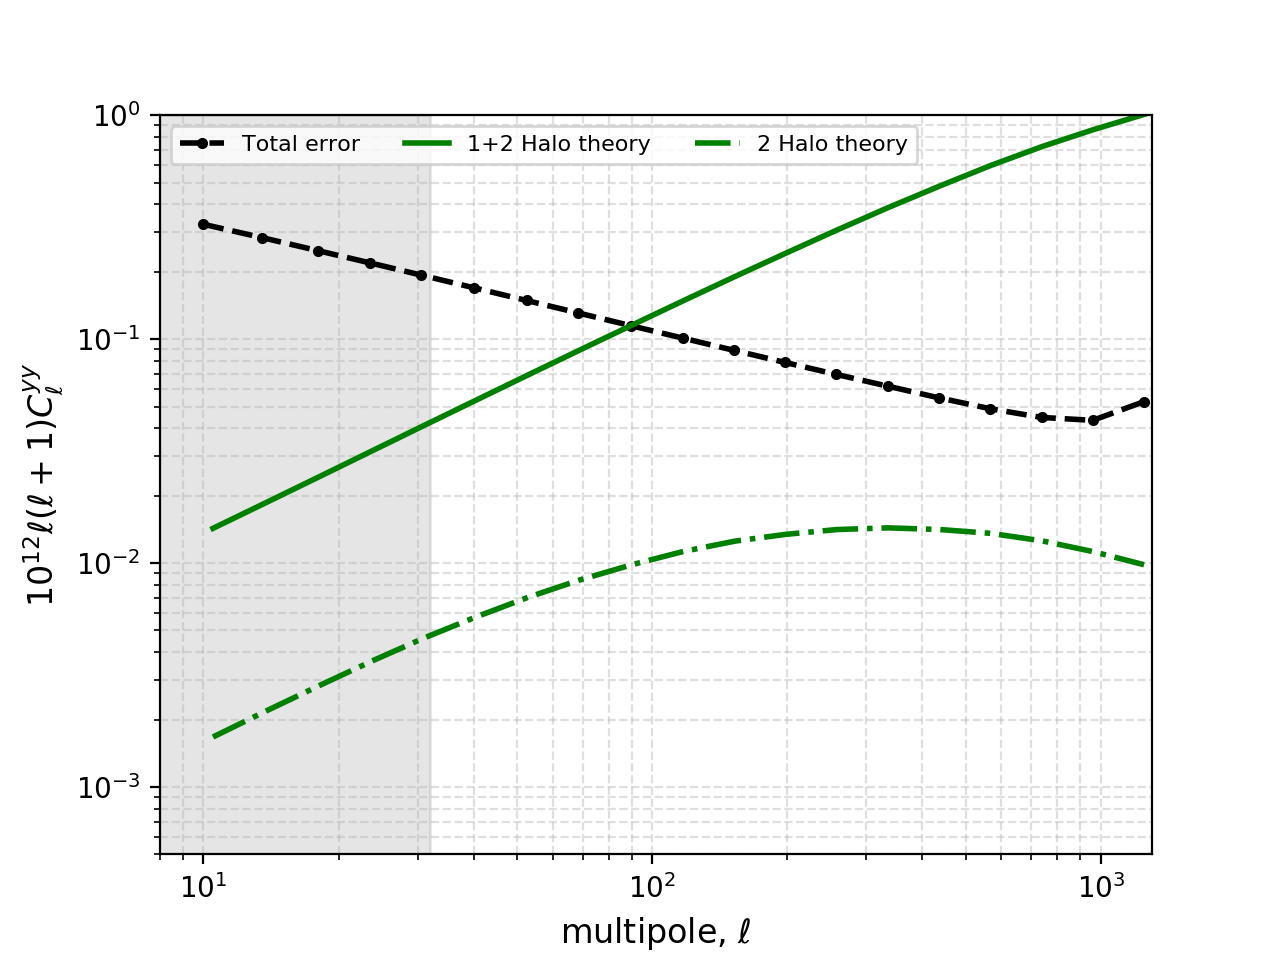

In [11]:
wdata="tot"
pldata=np.copy(tot)

figure()
# plot(pldata[:,2],pldata[:,3],"k.-",lw=2,label=r"Planck uRC")
plot(pldata[:,2],np.sqrt(pldata[:,4]**2. + (clyy[wdata]["fl"]*clyy[wdata]["1h_Terr"])**2.),"k.--",lw=2,label=r"Total error")

color="g" ; 
fl=clyy[wdata]["fl"]
plot(clyy[wdata]["ell"],fl*clyy[wdata]["1h2h"],"-",c=color,lw=2, label=r"1+2 Halo theory")
# plot(clyy[wdata]["ell"],fl*clyy[wdata]["1h"],"--",c=color,lw=2, label=r"1 Halo theory")
plot(clyy[wdata]["ell"],fl*clyy[wdata]["2h"],"-.",c=color,lw=2, label=r"2 Halo theory")


# plot(pldata[:,2],pldata[:,4],"m--",lw=2,label=r"Planck uRC G. error")
# plot(clyy[wdata]["ell"],fl*clyy[wdata]["1h_Terr"],"-.",c="m",lw=2, label=r"NG error",alpha=0.5)

axvspan(2,32,color="gray",alpha=0.2)
loglog()
ylabel("$10^{12} \ell(\ell+1) C_{\ell}^{yy}$", fontsize=12)
xlabel("multipole, $\ell$",fontsize=12)
grid(which="both",linestyle="dashed",alpha=0.4)
xlim(8,1300)
legend(loc="upper left",ncol=3,fontsize=8)
ylim(5e-4,1)
figname="../../results/yy_spec/2h_detectability_tot.pdf"
savefig(figname, bbox_inches="tight",dpi=200)
figname="../../results/yy_spec/2h_detectability_tot.jpeg"
savefig(figname, bbox_inches="tight",dpi=200)

<IPython.core.display.Javascript object>


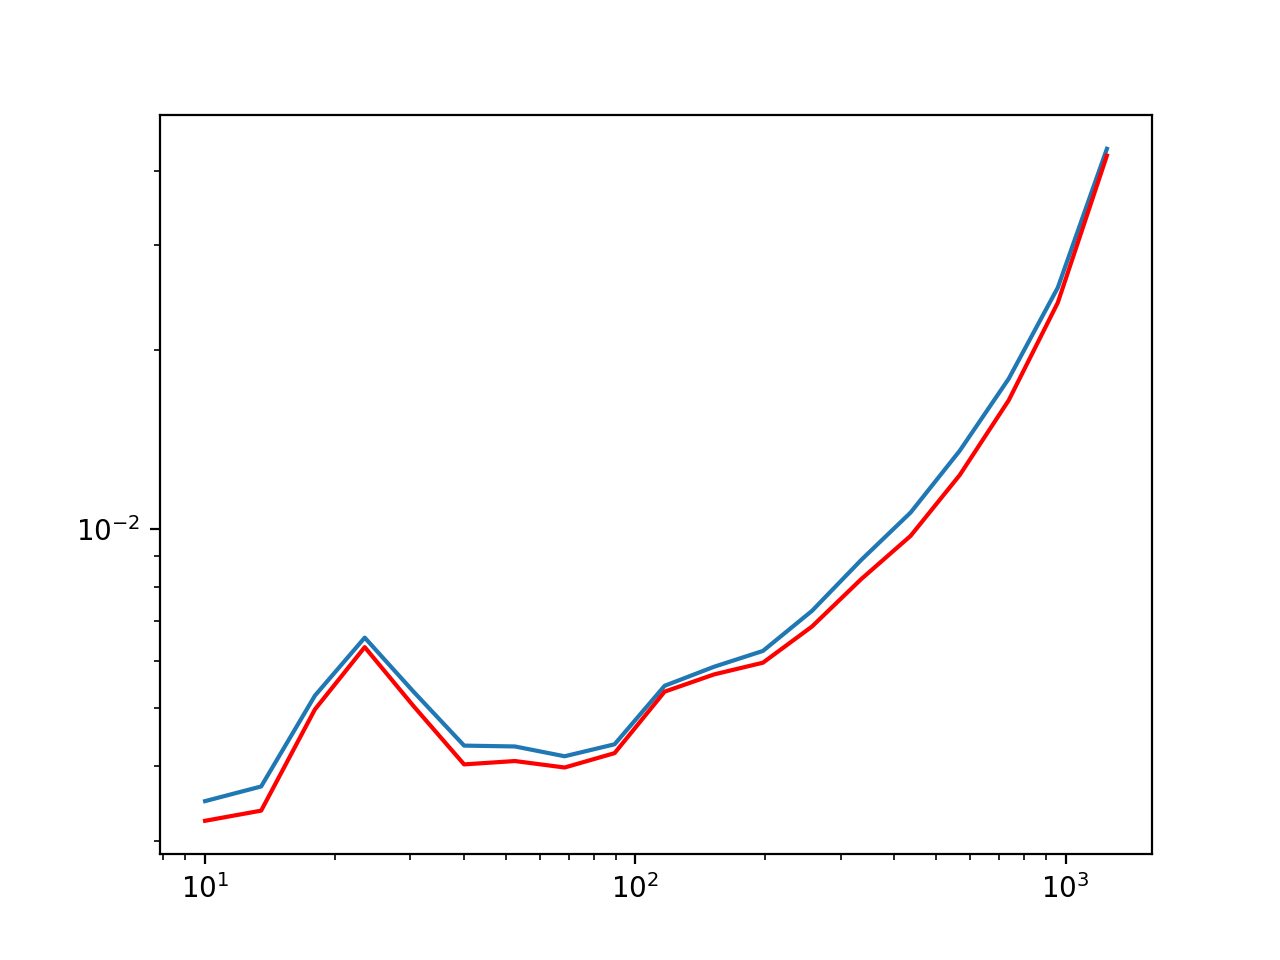

[]

In [47]:
figure()
wdata="urc6"
plot(pldata[:,2],np.sqrt(pldata[:,4]**2. + (clyy[wdata]["fl"]*clyy[wdata]["1h_Terr"])**2.))
plot(pldata[:,2],pldata[:,4],"r-")
loglog()

<IPython.core.display.Javascript object>


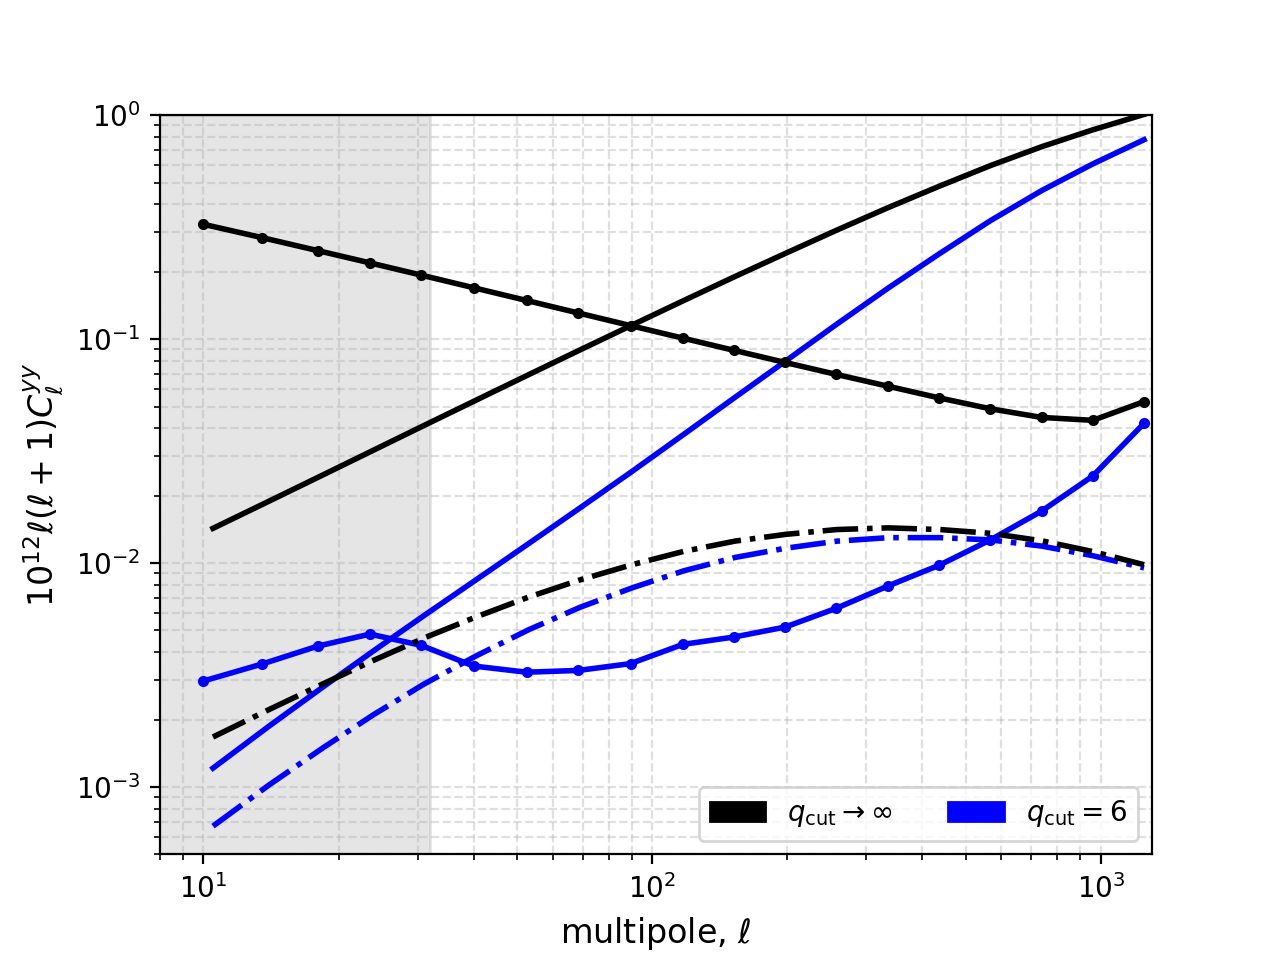

In [49]:
from matplotlib.patches import Patch

figure()

wdata="urc6"
pldata=np.copy(q6urc)
plot(pldata[:,2],np.sqrt(pldata[:,4]**2. + (clyy[wdata]["fl"]*clyy[wdata]["1h_Terr"])**2.),"b.-",lw=2,label=r"Total error")
# plot(pldata[:,2],pldata[:,4],"m-*",lw=2,label=r"Planck total Gaussian error",alpha=0.3)

color="b" ; 
fl=clyy[wdata]["fl"]
plot(clyy[wdata]["ell"],fl*clyy[wdata]["1h2h"],"-",c=color,lw=2, label=r"1+2 Halo theory")
plot(clyy[wdata]["ell"],fl*clyy[wdata]["2h"],"-.",c=color,lw=2, label=r"2 Halo theory")
# plot(pldata[:,2],pldata[:,4],"g-*",lw=2,label=r"Planck total Gaussian error",alpha=0.3)

wdata="tot"
pldata=np.copy(tot)
plot(pldata[:,2],np.sqrt(pldata[:,4]**2. + (clyy[wdata]["fl"]*clyy[wdata]["1h_Terr"])**2.),"k.-",lw=2,label=r"Total error")
# plot(pldata[:,2],pldata[:,4],"g-*",lw=2,label=r"Planck total Gaussian error",alpha=0.3)

color="k" ; 
fl=clyy[wdata]["fl"]
plot(clyy[wdata]["ell"],fl*clyy[wdata]["1h2h"],"-",c=color,lw=2, label=r"1+2 Halo theory")
plot(clyy[wdata]["ell"],fl*clyy[wdata]["2h"],"-.",c=color,lw=2, label=r"2 Halo theory")


legend_elements=[Patch(facecolor='black', edgecolor='k',label=r'$q_{\rm cut} \rightarrow \infty$'),
#                  Line2D([0], [0],marker=".",linestyle="-", color="k",label="Total error"),
#                  Line2D([0], [0],marker="*",linestyle="-", color="k",label="Gaussian error"),
                 Patch(facecolor='blue', edgecolor='b',label=r'$q_{\rm cut} = 6$'),
#                  Line2D([0], [0],marker=None,linestyle="-", color="k",label="1 + 2 Halo"),
#                  Line2D([0], [0],marker=None,linestyle="-.", color="k",label="2 Halo"),
                ]
legend(handles=legend_elements,ncol=2)
axvspan(2,32,color="gray",alpha=0.2)
loglog()
ylabel("$10^{12} \ell(\ell+1) C_{\ell}^{yy}$", fontsize=12)
xlabel("multipole, $\ell$",fontsize=12)
grid(which="both",linestyle="dashed",alpha=0.4)
xlim(8,1300)
# legend(ncol=3,fontsize=8)
ylim(5e-4,1)
figname="../../results/yy_spec/2h_detectability_qcut6.pdf"
savefig(figname, bbox_inches="tight",dpi=200)
figname="../../results/yy_spec/2h_detectability_qcut6.jpeg"
savefig(figname, bbox_inches="tight",dpi=200)

# Get frg spectral templates

In [13]:
data=np.loadtxt("/Users/adityarotti/Documents/Work/Data/Planck/maps/SZ_and_fg_models.txt")

<IPython.core.display.Javascript object>


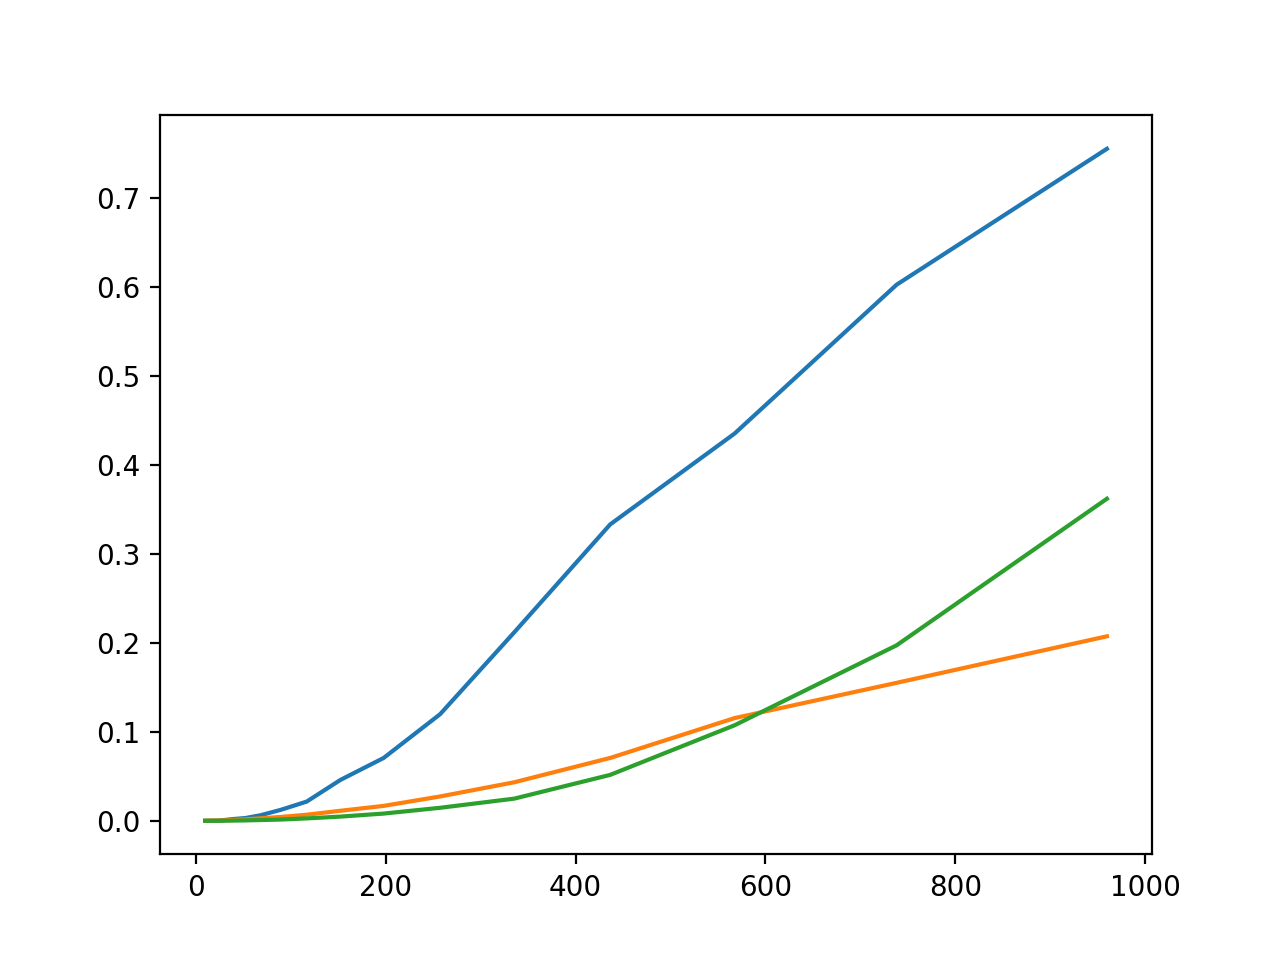

In [14]:
figure()
plot(data[:,0],data[:,3])
plot(data[:,0],data[:,4])
plot(data[:,0],data[:,5])

<IPython.core.display.Javascript object>


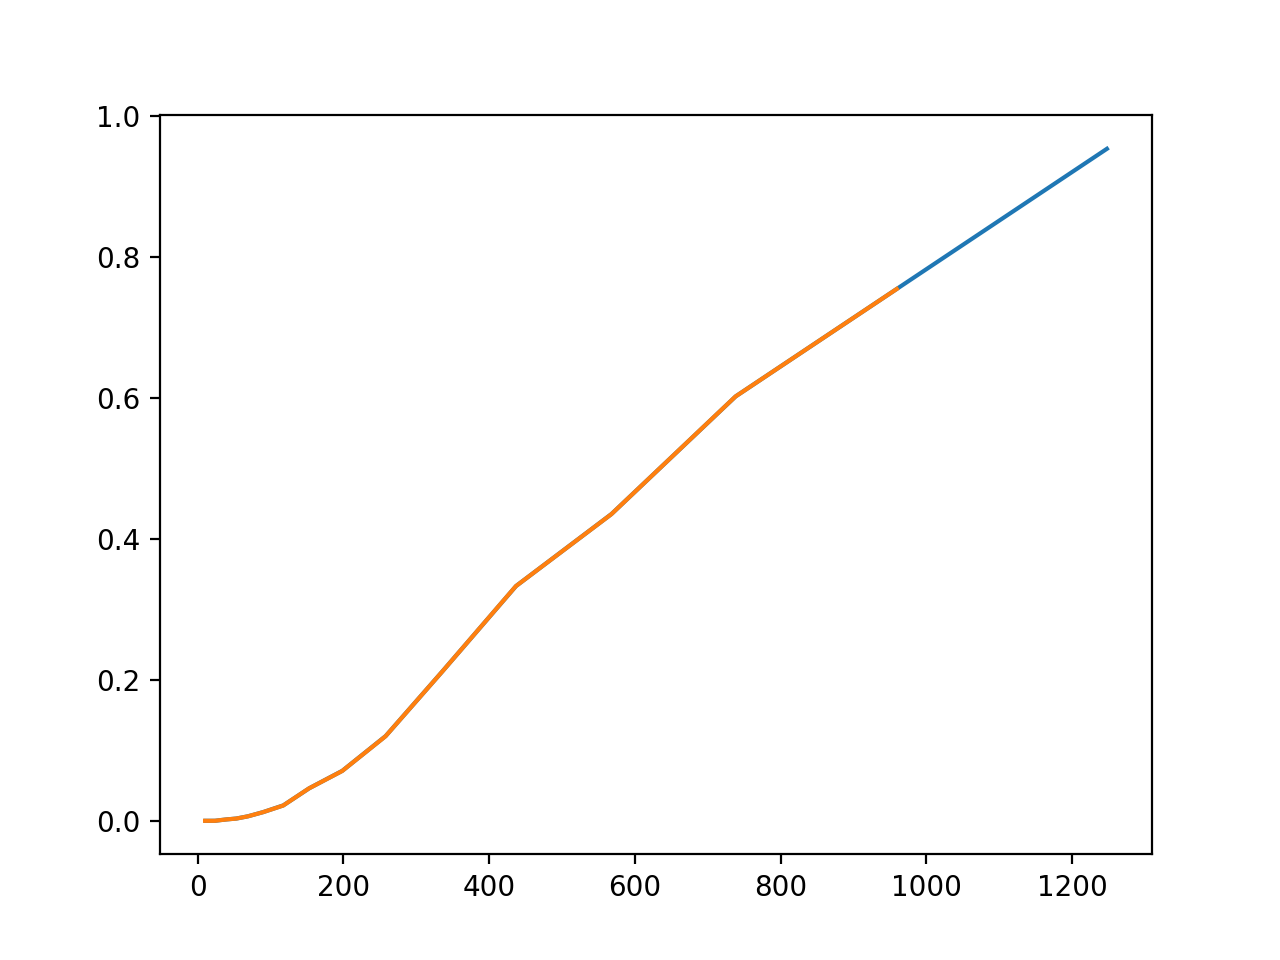

In [15]:
fn_cib=interp1d(data[:,0],data[:,3],fill_value="extrapolate")
cl_cib=fn_cib(clyy[wdata]["ell"])

figure()
plot(clyy[wdata]["ell"],cl_cib)
plot(data[:,0],data[:,3])

<IPython.core.display.Javascript object>


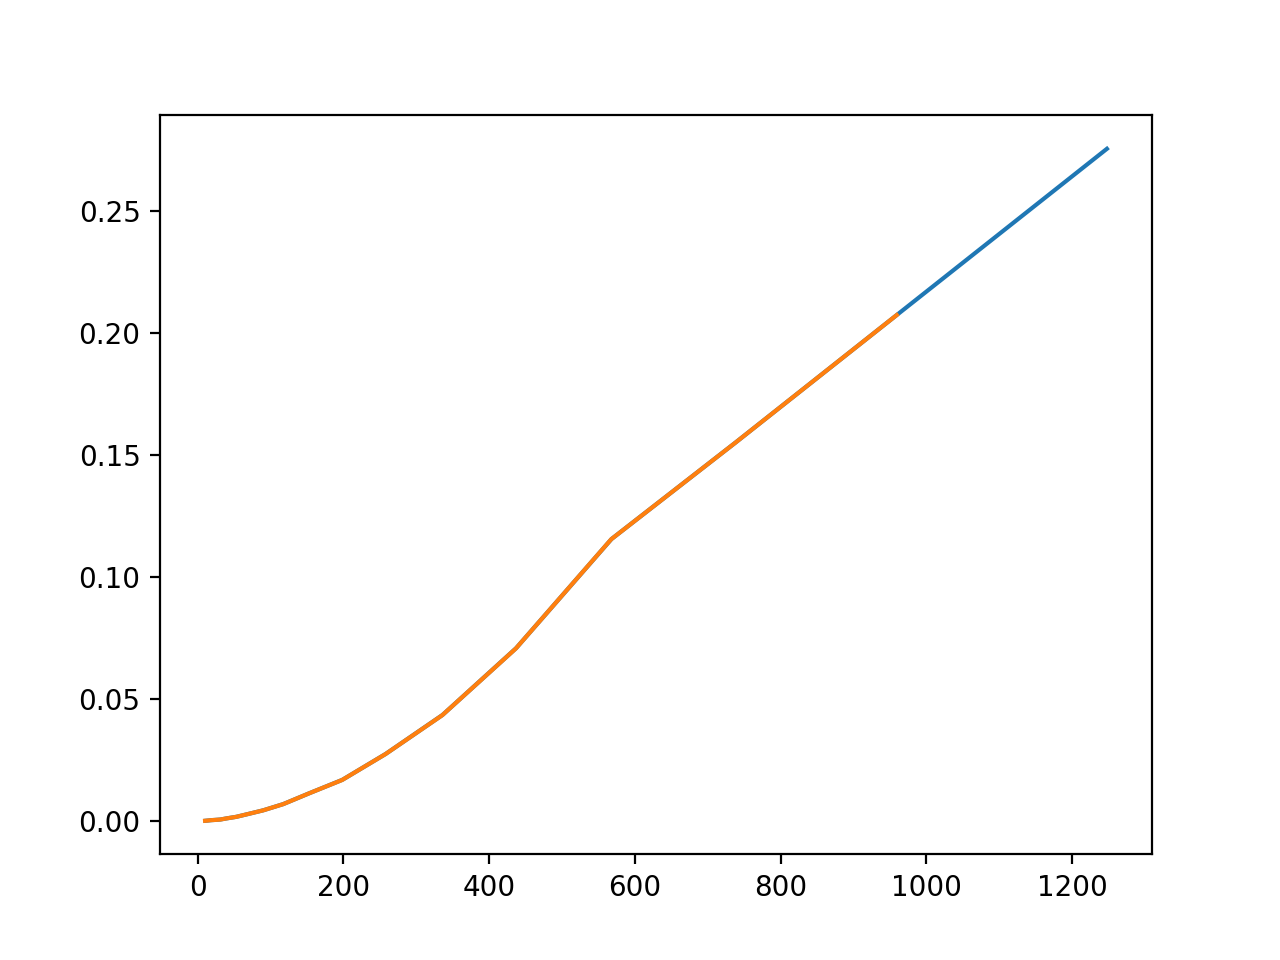

In [17]:
fn_rs=interp1d(data[:,0],data[:,4],fill_value="extrapolate")
cl_rs=fn_rs(clyy[wdata]["ell"])

figure()
plot(clyy[wdata]["ell"],cl_rs)
plot(data[:,0],data[:,4])

<IPython.core.display.Javascript object>


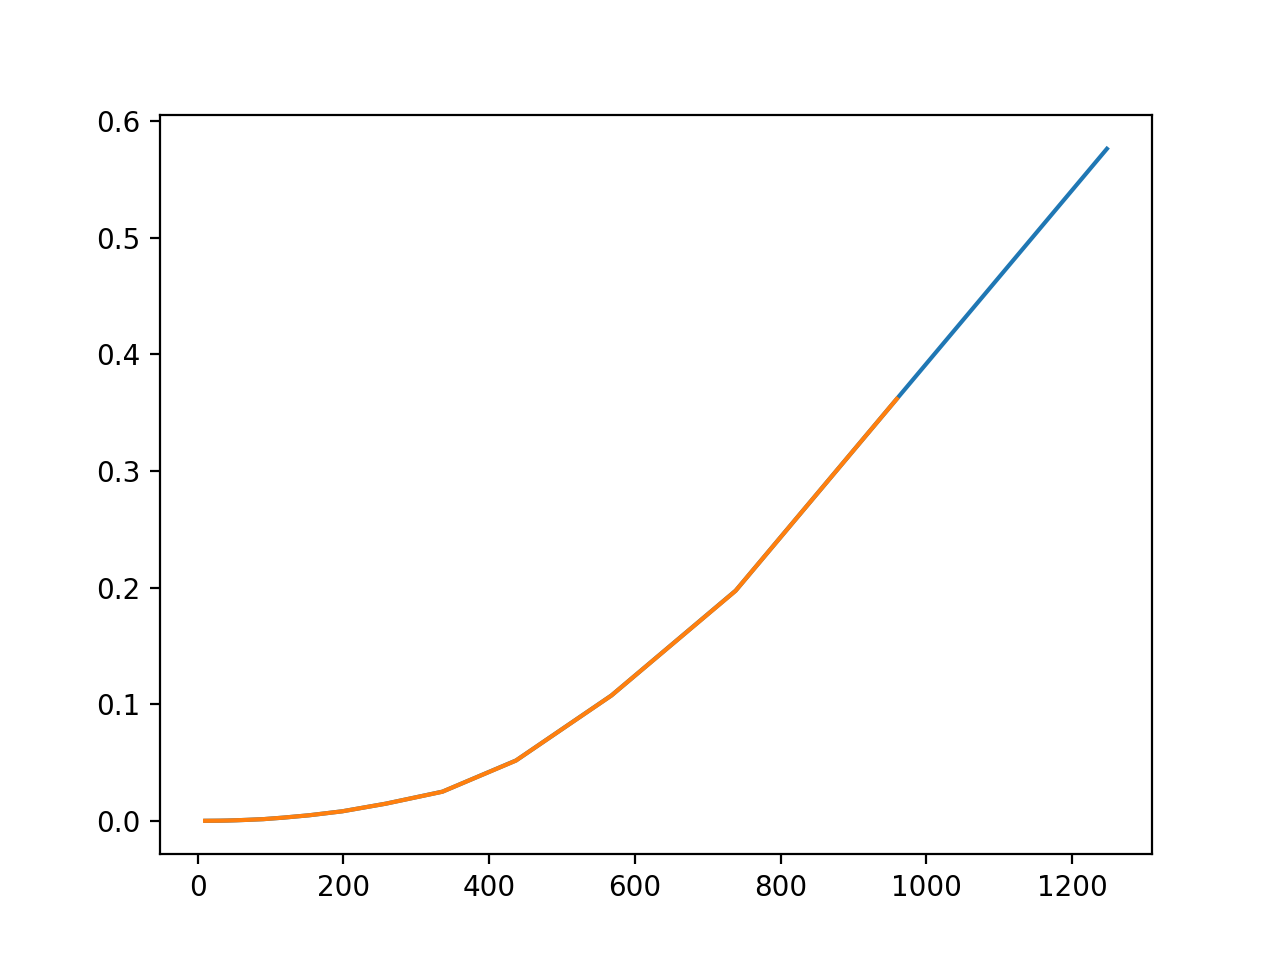

In [18]:
fn_ir=interp1d(data[:,0],data[:,5],fill_value="extrapolate")
cl_ir=fn_ir(clyy[wdata]["ell"])

figure()
plot(clyy[wdata]["ell"],cl_ir)
plot(data[:,0],data[:,5])

# Fisher analysis

F = $[C^{x}_{\ell},C^{CIB}_{\ell},C^{RS}_{\ell},C^{IR}_{\ell}] C^{-1}_{\ell \ell'}[C^{x}_{\ell'},C^{CIB}_{\ell'},C^{RS}_{\ell'},C^{IR}_{\ell'}]$

$ x \in [1h, {\rm Planck ~} yy - 1h, 1h2h, {\rm Planck ~} yy - 1h2h]$



$\sigma_x = \sqrt{F^{-1}_{00}}$ ; 
$\sigma_{CIB} = \sqrt{F^{-1}_{11}}$ ; 
$\sigma_{RS} = \sqrt{F^{-1}_{22}}$ ; 
$\sigma_{IR} = \sqrt{F^{-1}_{33}}$ 

In [14]:
snr_tab={}
snr_tab[r"$q_{\rm cut}=6$"]={}
wdata="urc6"
pldata=np.copy(q6urc)
err=np.sqrt((clyy[wdata]["fl"]*clyy[wdata]["1h_Terr"])**2. + pldata[:,4]**2.)
cov_inv=np.diag(1./err**2)

print "[yy,cib,rs,ir]"

svec=np.array([clyy[wdata]["1h2h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["1h2h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_1h2h=np.linalg.inv(F)
print "1 + 2 halo : ", 1./np.sqrt(np.diag(par_cov_1h2h))
snr_tab[r"$q_{\rm cut}=6$"]["1 + 2 halo"]=(1./np.sqrt(np.diag(par_cov_1h2h)))[0]

svec=np.array([clyy[wdata]["1h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["1h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_1h=np.linalg.inv(F)
print "1 halo :", 1./np.sqrt(np.diag(par_cov_1h))
snr_tab[r"$q_{\rm cut}=6$"]["1 halo"]=(1./np.sqrt(np.diag(par_cov_1h)))[0]

svec=np.array([clyy[wdata]["2h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["2h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_2h=np.linalg.inv(F)
print "2 halo : ", 1./np.sqrt(np.diag(par_cov_2h))
snr_tab[r"$q_{\rm cut}=6$"]["2 halo"]=(1./np.sqrt(np.diag(par_cov_2h)))[0]

###################################################


snr_tab[r"$q_{\rm cut} \rightarrow \infty$"]={}

wdata="tot"
pldata=np.copy(tot)
err=np.sqrt((clyy[wdata]["fl"]*clyy[wdata]["1h_Terr"])**2. + pldata[:,4]**2.)
cov_inv=np.diag(1./err**2)

print "[yy,cib,rs,ir]"

svec=np.array([clyy[wdata]["1h2h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["1h2h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_1h2h=np.linalg.inv(F)
print "1+2 halo : ", 1./np.sqrt(np.diag(par_cov_1h2h))
snr_tab[r"$q_{\rm cut} \rightarrow \infty$"]["1 + 2 halo"]=(1./np.sqrt(np.diag(par_cov_1h2h)))[0]

svec=np.array([clyy[wdata]["1h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["1h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_1h=np.linalg.inv(F)
print "1 halo :", 1./np.sqrt(np.diag(par_cov_1h))
snr_tab[r"$q_{\rm cut} \rightarrow \infty$"]["1 halo"]=(1./np.sqrt(np.diag(par_cov_1h)))[0]

svec=np.array([clyy[wdata]["2h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["2h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_2h=np.linalg.inv(F)
print "2 halo : ", 1./np.sqrt(np.diag(par_cov_2h))
snr_tab[r"$q_{\rm cut} \rightarrow \infty$"]["2 halo"]=(1./np.sqrt(np.diag(par_cov_2h)))[0]

[yy,cib,rs,ir]
1 + 2 halo :  [66.02898317]
1 halo : [61.9276086]
2 halo :  [6.14837038]
[yy,cib,rs,ir]
1+2 halo :  [36.4230662]
1 halo : [35.807714]
2 halo :  [0.70579435]


In [78]:
import pandas as pd

pd_snr_tab=pd.DataFrame(snr_tab).T
# pd_snr_tab.to_latex("../../results/yy_spec/frg_marg_snr_table.tex",na_rep="-",column_format="cccc",escape=False,float_format="%.1f")
pd_snr_tab.to_latex("../../results/yy_spec/snr_table.tex",na_rep="-",column_format="cccc",escape=False,float_format="%.1f")
pd_snr_tab

1 + 2 halo     1 halo    2 halo
$q_{\rm cut} \rightarrow \infty$   36.423066  35.807714  0.705794
$q_{\rm cut}=6$                    66.028983  61.927609  6.148370

## With full Trispectrum

### Interpolate the trispectrum

<IPython.core.display.Javascript object>


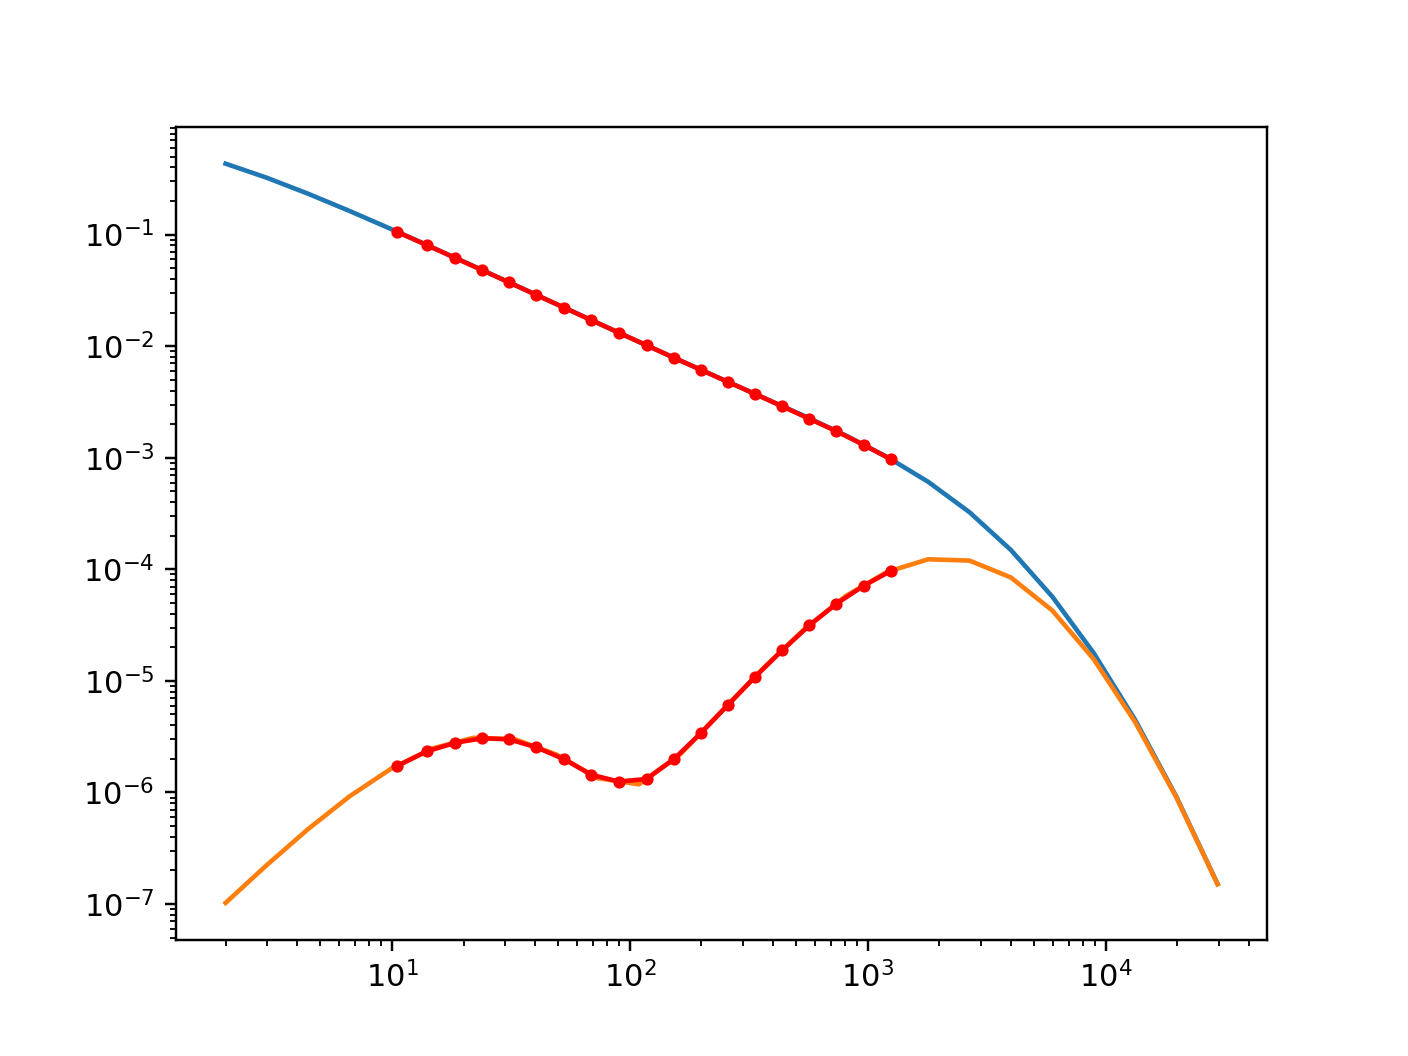

[]

In [18]:
data=loadtxt("../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_total.txt")
T_tot=np.loadtxt("../../tempdata/rotti_20_1_6_50/tSZ_trispectrum_ref_rotti++20_total_fsky_0d47.txt")/(4.*pi*0.354430)
T_urc6=np.loadtxt("../../tempdata/rotti_20_1_6_50/tSZ_trispectrum_ref_rotti++20_urc_snr6_fsky_0d35443.txt")/(4.*pi*0.354430)

fl=data[:,0]*(data[:,0]+1)/(2.*pi)
figure()
plot(data[:,0],diag(T_tot))
plot(data[:,0],diag(T_urc6))
plot(clyy["tot"]["ell"],(clyy["tot"]["1h_Terr"]*clyy["tot"]["fl"])**2.,"r.-")
plot(clyy["urc6"]["ell"],(clyy["urc6"]["1h_Terr"]*clyy["urc6"]["fl"])**2.,"r.-")
loglog()

<IPython.core.display.Javascript object>


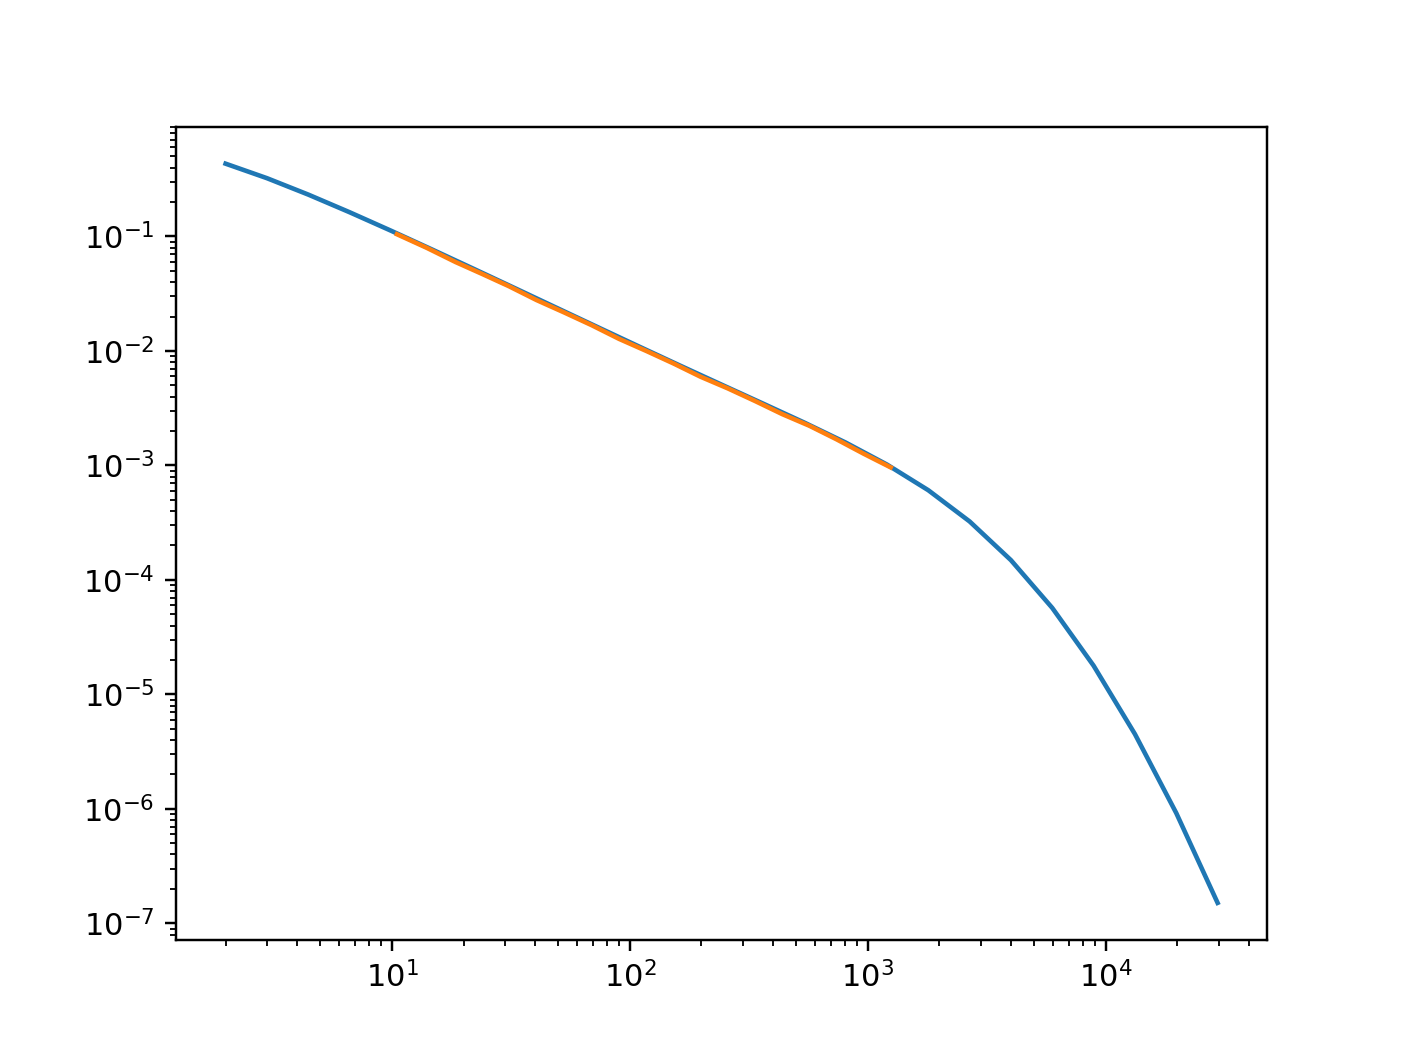

<IPython.core.display.Javascript object>


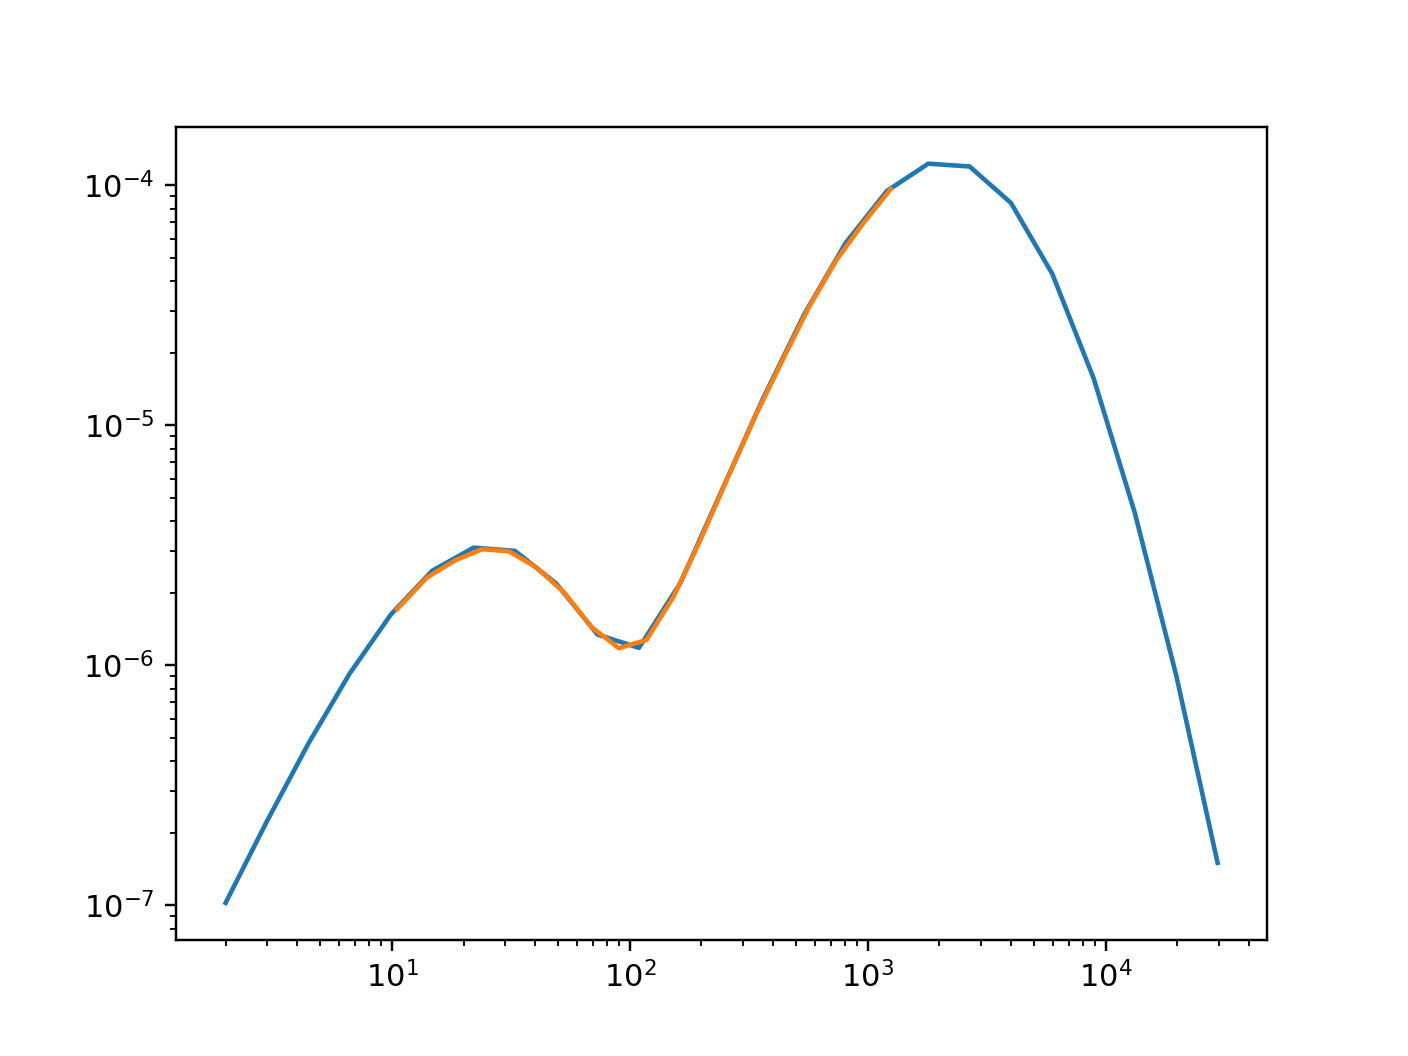

[]

In [15]:
from scipy.interpolate import interp2d

data=loadtxt("../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_total.txt")
fn_tot=interp2d(log10(data[:,0]),log10(data[:,0]),log10(T_tot))

cov_tot=np.zeros((len(ellp),len(ellp)),dtype=np.float64)
for i,lp1 in enumerate(ellp):
    for j,lp2 in enumerate(ellp):
        cov_tot[i,j]=10.**fn_tot(log10(lp1),log10(lp2))

figure()
plot(data[:,0],diag(T_tot))
plot(ellp,diag(cov_tot))
loglog()

data=loadtxt("../../tempdata/rotti_20_1_6_50/class-sz_szpowerspectrum_rotti++20_total.txt")
fn_urc6=interp2d(data[:,0],data[:,0],T_urc6)

cov_urc6=np.zeros((len(ellp),len(ellp)),dtype=np.float64)
for i,lp1 in enumerate(ellp):
    for j,lp2 in enumerate(ellp):
        cov_urc6[i,j]=fn_urc6(lp1,lp2)

figure()
plot(data[:,0],diag(T_urc6))
plot(ellp,diag(cov_urc6))
loglog()

### Fisher

<IPython.core.display.Javascript object>


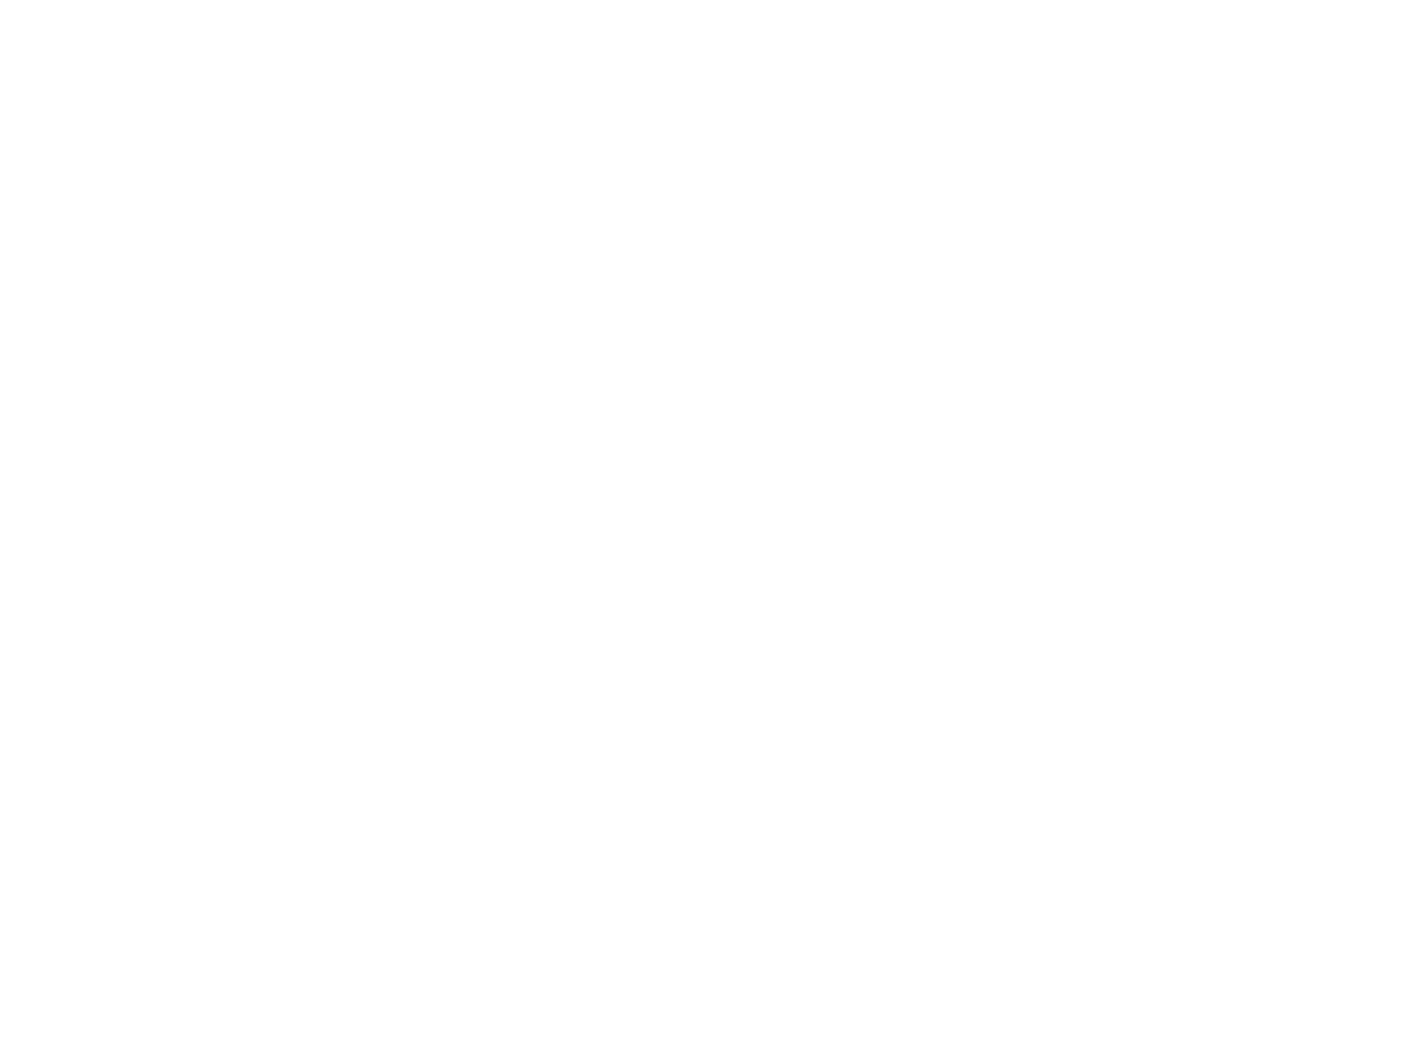

NameError: name 'cov_tot' is not defined

In [13]:
figure()
imshow(log10(cov_tot),origin="lower")
colorbar()

figure()
imshow(log10(cov_tot+np.diag(tot[:,4]**2.)),origin="lower")
colorbar()

figure()
imshow(log10(cov_urc6),origin="lower")
colorbar()

figure()
imshow(log10(cov_urc6+np.diag(q6urc[:,4]**2.)),origin="lower")
colorbar()

In [79]:
snr_tab={}
snr_tab[r"$q_{\rm cut}=6$"]={}
wdata="urc6"
pldata=np.copy(q6urc)
# cov=np.diag(np.diag(cov_urc6) + pldata[:,4]**2.)
cov=cov_urc6 + np.diag(pldata[:,4]**2.)
cov_inv=np.linalg.inv(cov)

print "[yy,cib,rs,ir]"

svec=np.array([clyy[wdata]["1h2h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["1h2h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_1h2h=np.linalg.inv(F)
print "1 + 2 halo : ", 1./np.sqrt(np.diag(par_cov_1h2h))
snr_tab[r"$q_{\rm cut}=6$"]["1 + 2 halo"]=(1./np.sqrt(np.diag(par_cov_1h2h)))[0]

svec=np.array([clyy[wdata]["1h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["1h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_1h=np.linalg.inv(F)
print "1 halo :", 1./np.sqrt(np.diag(par_cov_1h))
snr_tab[r"$q_{\rm cut}=6$"]["1 halo"]=(1./np.sqrt(np.diag(par_cov_1h)))[0]

svec=np.array([clyy[wdata]["2h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["2h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_2h=np.linalg.inv(F)
print "2 halo : ", 1./np.sqrt(np.diag(par_cov_2h))
snr_tab[r"$q_{\rm cut}=6$"]["2 halo"]=(1./np.sqrt(np.diag(par_cov_2h)))[0]

###################################################


snr_tab[r"$q_{\rm cut} \rightarrow \infty$"]={}

wdata="tot"
pldata=np.copy(tot)
# cov=np.diag(np.diag(cov_tot) + pldata[:,4]**2.)
cov=cov_tot + np.diag(pldata[:,4]**2.)
cov_inv=np.linalg.inv(cov)

print "[yy,cib,rs,ir]"

svec=np.array([clyy[wdata]["1h2h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["1h2h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_1h2h=np.linalg.inv(F)
print "1+2 halo : ", 1./np.sqrt(np.diag(par_cov_1h2h))
snr_tab[r"$q_{\rm cut} \rightarrow \infty$"]["1 + 2 halo"]=(1./np.sqrt(np.diag(par_cov_1h2h)))[0]

svec=np.array([clyy[wdata]["1h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["1h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_1h=np.linalg.inv(F)
print "1 halo :", 1./np.sqrt(np.diag(par_cov_1h))
snr_tab[r"$q_{\rm cut} \rightarrow \infty$"]["1 halo"]=(1./np.sqrt(np.diag(par_cov_1h)))[0]

svec=np.array([clyy[wdata]["2h"]*clyy[wdata]["fl"]])#,cl_cib,cl_rs,cl_ir])
# svec=np.array([clyy[wdata]["2h"]*clyy[wdata]["fl"],cl_cib,cl_rs,cl_ir])
F=np.dot(np.dot(svec,cov_inv),svec.T)
par_cov_2h=np.linalg.inv(F)
print "2 halo : ", 1./np.sqrt(np.diag(par_cov_2h))
snr_tab[r"$q_{\rm cut} \rightarrow \infty$"]["2 halo"]=(1./np.sqrt(np.diag(par_cov_2h)))[0]

[yy,cib,rs,ir]
1 + 2 halo :  [46.91045005]
1 halo : [44.60901414]
2 halo :  [4.58785035]
[yy,cib,rs,ir]
1+2 halo :  [24.60743833]
1 halo : [24.37591118]
2 halo :  [0.3039178]


# Paper figures

In [215]:
planckyy=np.loadtxt(datapath + "/maps/planck2015_yy_ps.txt")
bmin=planckyy[:,3]
bmax=planckyy[:,4]

# Data from Boris's papers
planck_yy=np.loadtxt(datapath + "/maps/bolliet2018.txt")

In [223]:
lc={}
lc["planck"]="black"
lc["planck_rc"]="gray"

<IPython.core.display.Javascript object>


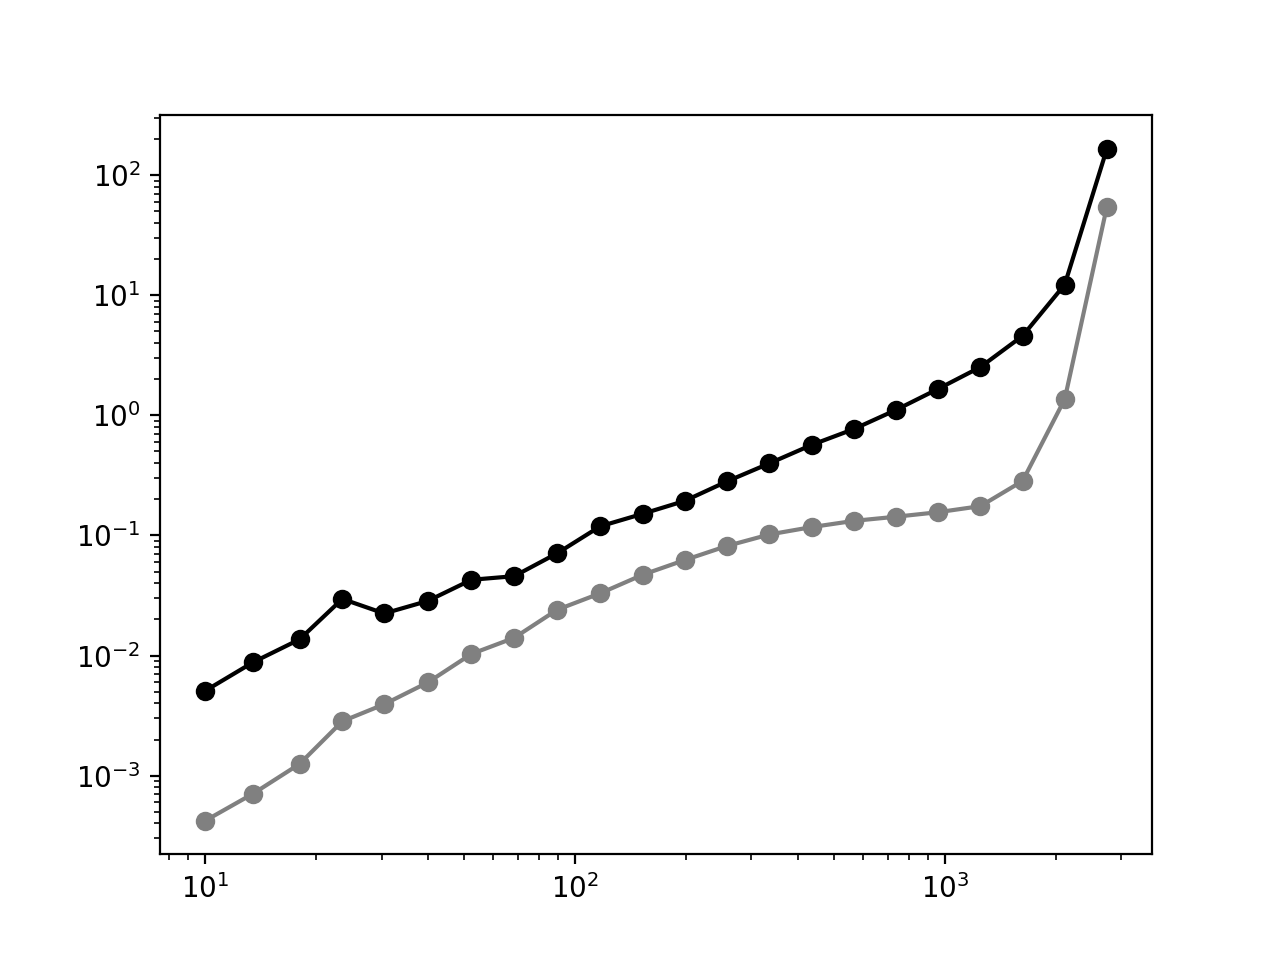

[]

In [226]:
figure()
plot(planck_yy[:,0],planck_yy[:,3],"o-",c=lc["planck_rc"])
plot(planck_yy[:,0],planck_yy[:,1],"o-",c=lc["planck"])
loglog()

In [239]:
tot=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/total_yy_spec.txt")
q6urc=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
q6rc=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")

<IPython.core.display.Javascript object>


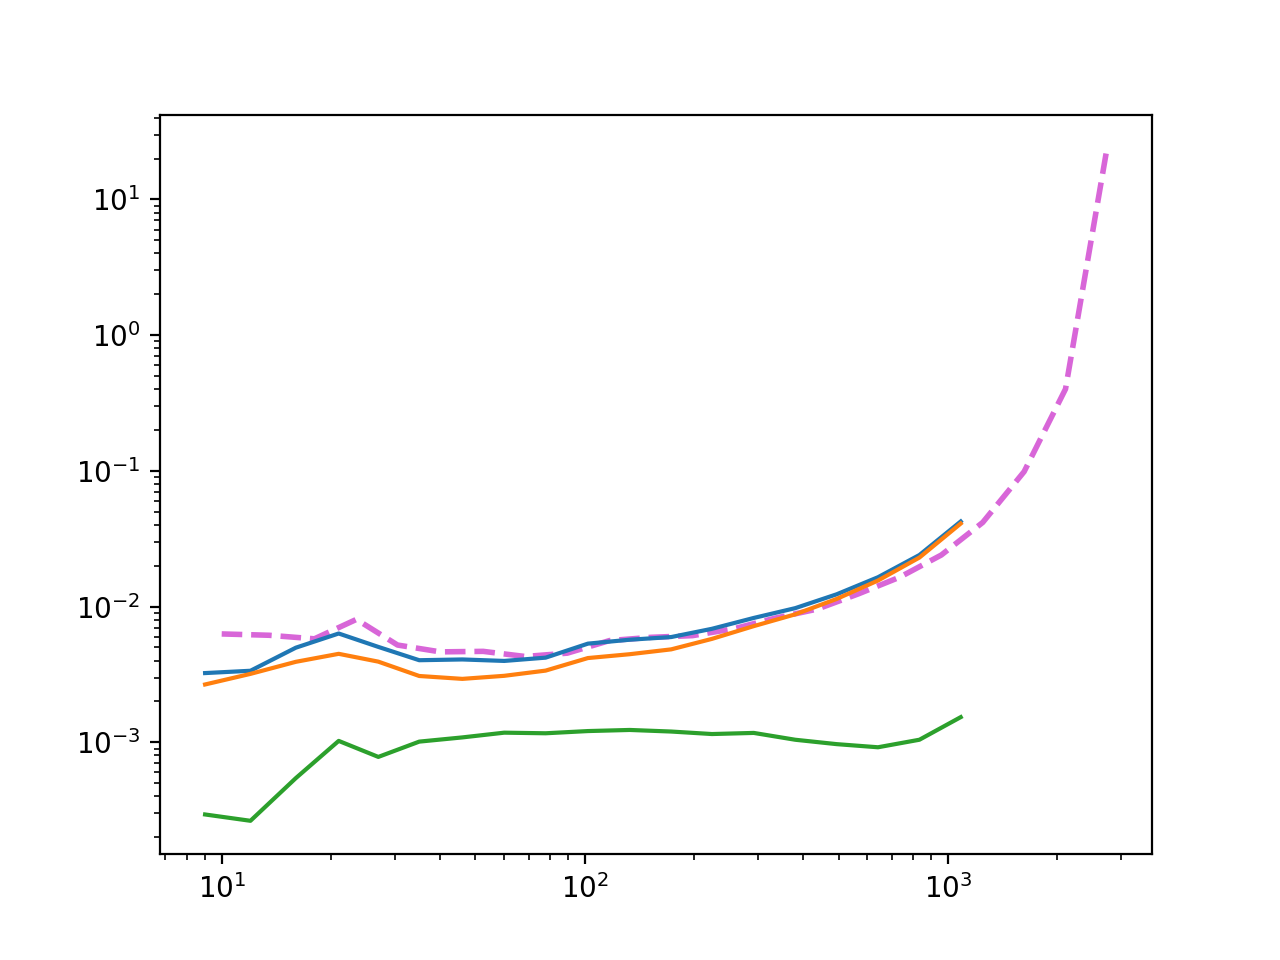

[]

In [243]:
figure()
plot(planck_yy[:,0],planck_yy[:,2],"m--",lw=2,label="Planck 2015 data",alpha=0.6)
plot(tot[:,0],tot[:,4])
plot(q6urc[:,0],q6urc[:,4])
plot(q6rc[:,0],q6rc[:,4])
loglog()

<IPython.core.display.Javascript object>


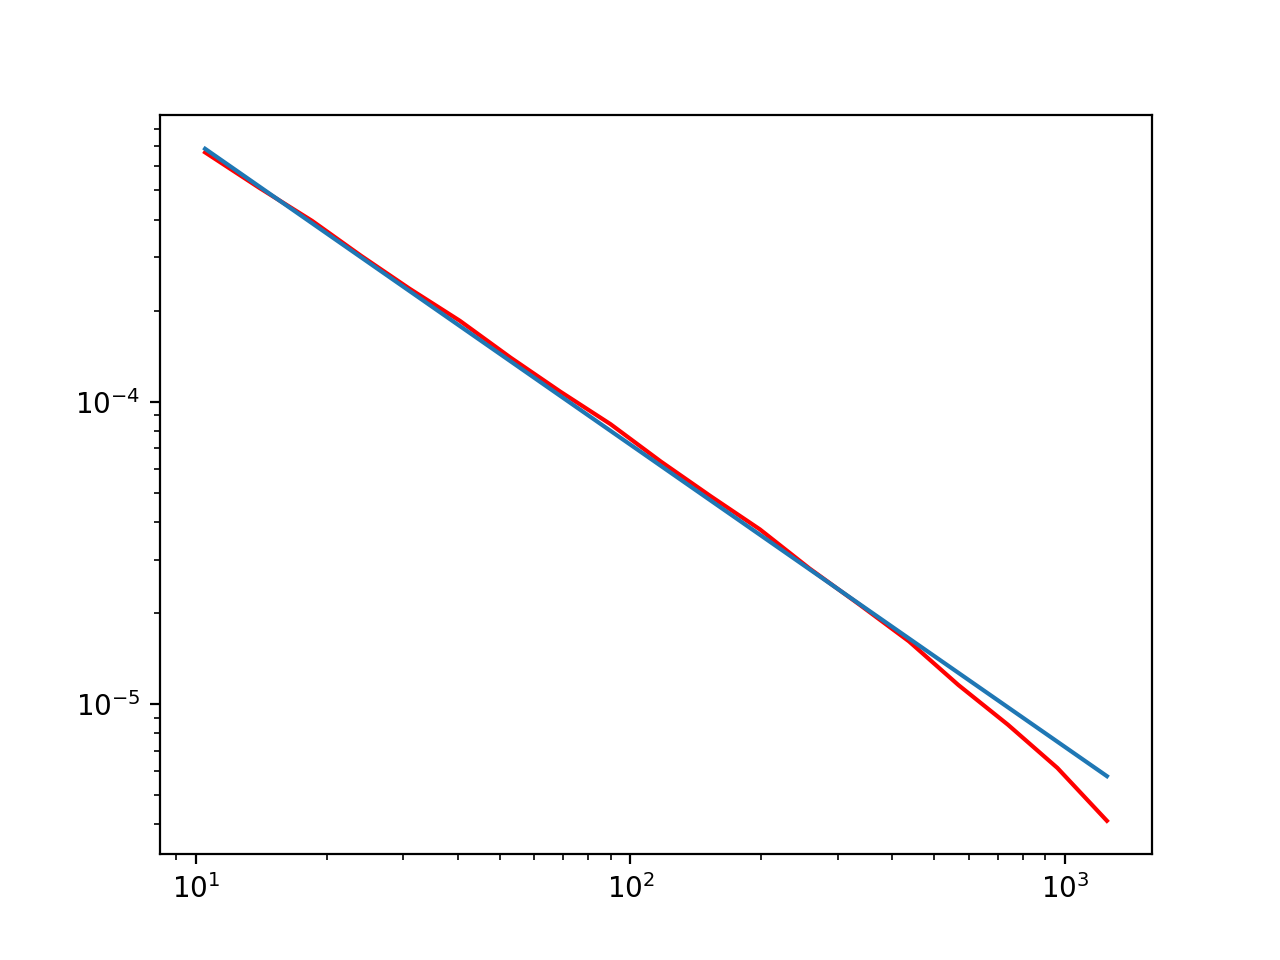

[]

In [265]:
figure()
plot(clyy["tot"]["ell"],clyy["tot"]["1h"],"r-")
plot(clyy["tot"]["ell"],7.2e-3/clyy["tot"]["ell"])
loglog()